## -- Light GBM --

### -- feature 생성 --

In [15]:
"""
Creates comprehensive features from acoustic data in 150k segments
Optimized for Google Colab environment
"""

import numpy as np
import pandas as pd
from scipy import stats, signal, fft
from scipy.stats import skew, kurtosis
import librosa
import warnings
import os
os.environ["TSFRESH_NO_Numba"] = "1"

warnings.filterwarnings('ignore')

# Configuration
INPUT_FILE = r"/content/drive/MyDrive/Colab Notebooks/train/train_17.csv"
X_OUTPUT_FILE = "features_17.csv"
Y_OUTPUT_FILE = "target_17.csv"
SEGMENT_SIZE = 150_000
ROLLING_WINDOW = 1000
N_MFCC = 13
N_FFT_BINS = 10

print("=" * 80)
print("FEATURE ENGINEERING PIPELINE")
print("=" * 80)
print(f"Input file: {INPUT_FILE}")
print(f"X_Output file: {X_OUTPUT_FILE}")
print(f"Y_Output file: {Y_OUTPUT_FILE}")
print(f"Segment size: {SEGMENT_SIZE:,}")
print(f"Rolling window: {ROLLING_WINDOW:,}")
print(f"MFCC coefficients: {N_MFCC}")
print(f"FFT bins: {N_FFT_BINS}")
print("=" * 80)


def calculate_basic_statistics(data):
    """Calculate basic statistical features"""
    features = {}

    # Basic stats
    features['mean'] = np.mean(data)
    features['median'] = np.median(data)
    features['min'] = np.min(data)
    features['max'] = np.max(data)
    features['range'] = features['max'] - features['min']
    features['std'] = np.std(data)
    features['variance'] = np.var(data)

    # Quantiles
    features['q25'] = np.percentile(data, 25)
    features['q50'] = np.percentile(data, 50)
    features['q75'] = np.percentile(data, 75)
    features['iqr'] = features['q75'] - features['q25']

    # Higher moments
    features['skewness'] = skew(data)
    features['kurtosis'] = kurtosis(data)

    return features


def calculate_rolling_statistics(data, window=ROLLING_WINDOW):
    """Calculate rolling statistics features"""
    features = {}

    # Create pandas series for rolling calculations
    series = pd.Series(data)

    # Rolling mean
    rolling_mean = series.rolling(window=window, min_periods=1).mean()
    features['rolling_mean_mean'] = rolling_mean.mean()
    features['rolling_mean_std'] = rolling_mean.std()
    features['rolling_mean_min'] = rolling_mean.min()
    features['rolling_mean_max'] = rolling_mean.max()

    # Rolling min
    rolling_min = series.rolling(window=window, min_periods=1).min()
    features['rolling_min_mean'] = rolling_min.mean()
    features['rolling_min_std'] = rolling_min.std()

    # Rolling max
    rolling_max = series.rolling(window=window, min_periods=1).max()
    features['rolling_max_mean'] = rolling_max.mean()
    features['rolling_max_std'] = rolling_max.std()

    # Rolling quantiles
    rolling_q25 = series.rolling(window=window, min_periods=1).quantile(0.25)
    rolling_q50 = series.rolling(window=window, min_periods=1).quantile(0.50)
    rolling_q75 = series.rolling(window=window, min_periods=1).quantile(0.75)

    features['rolling_q25_mean'] = rolling_q25.mean()
    features['rolling_q50_mean'] = rolling_q50.mean()
    features['rolling_q75_mean'] = rolling_q75.mean()

    # Exponential weighted moving average
    ewma = series.ewm(span=window, min_periods=1).mean()
    features['ewma_mean'] = ewma.mean()
    features['ewma_std'] = ewma.std()
    features['ewma_min'] = ewma.min()
    features['ewma_max'] = ewma.max()

    return features


def calculate_signal_features(data):
    """Calculate signal processing features"""
    features = {}

    # Zero crossing rate
    zero_crossings = np.where(np.diff(np.sign(data)))[0]
    features['zero_crossing_rate'] = len(zero_crossings) / len(data)

    # Peak features
    peaks, properties = signal.find_peaks(data, height=0)
    features['num_peaks'] = len(peaks)
    features['peak_mean_height'] = np.mean(properties['peak_heights']) if len(peaks) > 0 else 0
    features['peak_max_height'] = np.max(properties['peak_heights']) if len(peaks) > 0 else 0
    features['peak_std_height'] = np.std(properties['peak_heights']) if len(peaks) > 0 else 0

    # Negative peaks
    neg_peaks, neg_properties = signal.find_peaks(-data, height=0)
    features['num_neg_peaks'] = len(neg_peaks)
    features['neg_peak_mean_height'] = np.mean(neg_properties['peak_heights']) if len(neg_peaks) > 0 else 0
    features['neg_peak_max_height'] = np.max(neg_properties['peak_heights']) if len(neg_peaks) > 0 else 0

    return features


def calculate_spectral_features(data, sr=4000000):
    """Calculate spectral features using librosa and scipy"""
    features = {}

    # Normalize data for librosa (expects float32 between -1 and 1)
    data_normalized = data.astype(np.float32)
    if np.max(np.abs(data_normalized)) > 0:
        data_normalized = data_normalized / np.max(np.abs(data_normalized))

    # Spectral centroid
    spectral_cent = librosa.feature.spectral_centroid(y=data_normalized, sr=sr)[0]
    features['spectral_centroid_mean'] = np.mean(spectral_cent)
    features['spectral_centroid_std'] = np.std(spectral_cent)
    features['spectral_centroid_min'] = np.min(spectral_cent)
    features['spectral_centroid_max'] = np.max(spectral_cent)

    # Spectral rolloff
    spectral_roll = librosa.feature.spectral_rolloff(y=data_normalized, sr=sr)[0]
    features['spectral_rolloff_mean'] = np.mean(spectral_roll)
    features['spectral_rolloff_std'] = np.std(spectral_roll)
    features['spectral_rolloff_min'] = np.min(spectral_roll)
    features['spectral_rolloff_max'] = np.max(spectral_roll)

    # MFCC
    mfccs = librosa.feature.mfcc(y=data_normalized, sr=sr, n_mfcc=N_MFCC)
    for i in range(N_MFCC):
        features[f'mfcc_{i}_mean'] = np.mean(mfccs[i])
        features[f'mfcc_{i}_std'] = np.std(mfccs[i])

    # FFT features
    fft_values = np.abs(fft.fft(data))
    fft_freq = fft.fftfreq(len(data), 1/sr)

    # Get top N_FFT_BINS frequency magnitudes
    sorted_indices = np.argsort(fft_values)[::-1]
    for i in range(N_FFT_BINS):
        features[f'fft_magnitude_{i}'] = fft_values[sorted_indices[i]]
        features[f'fft_frequency_{i}'] = np.abs(fft_freq[sorted_indices[i]])

    return features

def extract_all_features(segment_data):
    """Extract all features from a segment"""
    segment_data = segment_data - np.median(segment_data)
    noise = np.random.normal(0, 0.01, len(segment_data))
    segment_data = segment_data + noise

    print("  - Extracting basic statistics...")
    features = calculate_basic_statistics(segment_data)

    print("  - Extracting rolling statistics...")
    features.update(calculate_rolling_statistics(segment_data))

    print("  - Extracting signal features...")
    features.update(calculate_signal_features(segment_data))

    print("  - Extracting spectral features...")
    features.update(calculate_spectral_features(segment_data))

    return features


def process_data():
    """Main processing function"""
    print("\n[1/5] Reading CSV file...")
    df = pd.read_csv(INPUT_FILE)
    print(f"  Total rows: {len(df):,}")

    acoustic_data = df['acoustic_data'].values
    time_to_failure = df['time_to_failure'].values
    total_rows = len(acoustic_data)

    # Calculate number of segments
    num_segments = int(np.ceil(total_rows / SEGMENT_SIZE))
    remainder = total_rows % SEGMENT_SIZE

    print(f"\n[2/5] Segmentation info:")
    print(f"  Total data points: {total_rows:,}")
    print(f"  Segment size: {SEGMENT_SIZE:,}")
    print(f"  Number of segments: {num_segments}")
    print(f"  Remainder: {remainder:,}")

    # Split data into segments (from back to front)
    print(f"\n[3/5] Creating segments...")
    segments = []
    target_y = []

    if remainder == 0:
        # Perfect division
        for i in range(num_segments):
            start_idx = i * SEGMENT_SIZE
            end_idx = start_idx + SEGMENT_SIZE
            segments.append(acoustic_data[start_idx:end_idx])
            target_y.append(time_to_failure[end_idx - 1])
    else:
        # Need padding for first segment
        # Take complete segments from the back
        complete_segments_start = remainder

        # First segment (with padding)
        first_segment = acoustic_data[:complete_segments_start]
        first_segment_mean = np.mean(first_segment)
        padding_needed = SEGMENT_SIZE - remainder
        padded_segment = np.concatenate([
            np.full(padding_needed, first_segment_mean),
            first_segment
        ])
        segments.append(padded_segment)
        target_y.append(time_to_failure[complete_segments_start - 1])
        print(f"  First segment padded with {padding_needed:,} values (mean: {first_segment_mean:.2f})")

        # Remaining complete segments
        for i in range(num_segments - 1):
            start_idx = complete_segments_start + i * SEGMENT_SIZE
            end_idx = start_idx + SEGMENT_SIZE
            segments.append(acoustic_data[start_idx:end_idx])
            target_y.append(time_to_failure[end_idx - 1])

    print(f"  Created {len(segments)} segments and {len(target_y)} targets")

    # Extract features for each segment
    print(f"\n[4/5] Extracting features from each segment...")
    all_segment_features = []

    for seg_idx, segment in enumerate(segments):
        print(f"\nProcessing segment {seg_idx + 1}/{len(segments)}...")
        segment_features = extract_all_features(segment)
        all_segment_features.append(segment_features)

    # Create output DataFrame with original data + features
    print(f"\n[5/5] Creating output DataFrame...")

    x_train_final = pd.DataFrame(all_segment_features)
    y_train_final = pd.Series(target_y, name = 'time_to_failure')

    # Save to CSV
    print(f"\n[6/6] Saving to {X_OUTPUT_FILE} and {Y_OUTPUT_FILE}...")
    x_train_final.to_csv(X_OUTPUT_FILE, index=False)
    y_train_final.to_csv(Y_OUTPUT_FILE, index=False)

    print("\n" + "=" * 80)
    print("FEATURE ENGINEERING COMPLETE!")
    print("=" * 80)

if __name__ == "__main__":
    process_data()

KeyboardInterrupt: 

## --- Feature 각자 생성한거 합치기 ---


In [ ]:
import glob
import pandas as pd
import numpy as np

Feature_path = sorted(glob.glob(r'/content/drive/MyDrive/Colab Notebooks/features/*.csv'))
Output_path = sorted(glob.glob(r'/content/drive/MyDrive/Colab Notebooks/output/*.csv'))

final_feature_li = []
final_target_li = []

for file_path in Feature_path:
  feature = pd.read_csv(file_path)
  final_feature_li.append(feature)

for file_path in Output_path:
  target = pd.read_csv(file_path)
  final_target_li.append(target)

final_feature = pd.concat(final_feature_li, ignore_index=True)
final_target = pd.concat(final_target_li, ignore_index=True)

final_feature.to_csv('final_feature.csv', index=False)
final_target.to_csv('final_target.csv', index=False)

## --- Feature 중요도 확인 ---

### 통계적 feature

### using Random Forest

In [ ]:
import pandas as pd

data = pd.read_csv('/kaggle/input/final-data/final_feature.csv')

data

In [ ]:
output = pd.read_csv('/kaggle/input/final-data/final_target.csv')

output

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

R_output = pd.read_csv('/kaggle/input/final-data/final_target.csv').squeeze()

k = 5
sample_size = len(data) // k
num_epochs = 100
N_split = 5
kf = KFold(n_splits=N_split, shuffle=True, random_state=42)

rf_feature_importance_li = []

print(f"--- {N_split}-Fold 교차 검증으로 특징 중요도 계산 중 ---")

for i in range(k):
    print(f" --- {i+1} 번째 Fold 실행 ---")

    # 모델 구현
    model = RandomForestRegressor(n_estimators=100, random_state=i, n_jobs=-1)
    model.fit(data, R_output)

    # 중요성 확인
    rf_feature_importance_li.append(model.feature_importances_)

In [ ]:
final_importances = np.mean(rf_feature_importance_li, axis=0)

#feature 중요도 시각화
feature = data.columns
importance_df = pd.DataFrame({'Feature': feature, 'Importance': final_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 25))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance with Random Forest and K-Fold')
plt.gca().invert_yaxis()
plt.show()

# importance_df.to_csv('rf_feature_importance.csv', index=False)

### using Lightgbm
- early_stopping_rounds : 조기중단을 위한 반복 횟수 정의
- eval_metric : 조기중단을 위한 평가지표
- eval_set : 검증 세트를 지정하는 것으로, 학습은 학습 데이터로 하되 예측 오류값 평가는 eval_set로 지정된 검증 세트로 평가하는 방식

In [ ]:
from re import VERBOSE
import lightgbm as lgb

lgb_feature_importance_li = []

k = 5
sample_size = len(data) // k

print(f"--- {k}-Fold 교차 검증으로 특징 중요도 계산 중 ---")

for i in range(k):
    print(f"--- {i+1} Fold ---")
    
    val_data = data.iloc[i*sample_size : (i+1)*sample_size]
    val_target = R_output.iloc[i*sample_size : (i+1)*sample_size]
    train_data = np.concatenate([data.iloc[:i*sample_size], data.iloc[(i+1)*sample_size:]], axis=0)
    train_target = np.concatenate([R_output.iloc[:i*sample_size], R_output.iloc[(i+1)*sample_size:]], axis=0)

    model = lgb.LGBMRegressor(n_estimators=100, random_state=fold)
    model.fit(train_data, train_target,
                eval_set=[(val_data, val_target)], eval_metric='mae')
    
    lgb_feature_importance_li.append(model.feature_importances_)

lgb_feature_importances = np.mean(lgb_feature_importance_li, axis=0)

lgb_importance_df = pd.DataFrame({'Feature': feature, 'Importance': lgb_feature_importances})
lgb_importance_df = lgb_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,25))
plt.barh(lgb_importance_df['Feature'], lgb_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance with LigthGBM')
plt.gca().invert_yaxis()
plt.show()


## --- 상관관계 확인 ---

In [ ]:
import seaborn as sns
corr = data.corr()
corr

In [3]:
# 중요도가 높은 feature 10개 뽑기
import pandas as pd
data = pd.read_csv('/kaggle/input/final-data/final_feature.csv')
features_10_li =['mfcc_5_mean','mfcc_2_std', 'mfcc_5_std',
                 'iqr', 'zero_crossing_rate',
                 'mfcc_12_mean', 'mfcc_8_mean',
                 'mfcc_8_std', 'mfcc_6_std','spectral_centroid_mean'
                 ]

Top_10_features = data[features_10_li]
Top_10_features

,mfcc_5_mean,mfcc_2_std,mfcc_5_std,iqr,zero_crossing_rate,mfcc_12_mean,mfcc_8_mean,mfcc_8_std,mfcc_6_std,spectral_centroid_mean
0,7.814365,37.944523,7.435091,2.020694,0.359707,-2.878186,4.989439,5.480338,6.870988,806035.199333
1,9.475658,9.123167,6.616029,4.992544,0.308820,-3.538423,7.151297,5.262962,5.405343,737796.200142
2,11.879259,9.243945,5.848944,4.994955,0.302567,-3.641933,8.119328,4.691262,6.115665,721997.473197
3,7.929636,12.323685,7.944710,5.006284,0.288940,-4.632163,6.665100,5.665137,6.901661,702225.316447
4,9.522389,11.508546,7.111937,4.031656,0.298500,-3.713416,7.411014,5.795504,8.349730,719055.905323
...,...,...,...,...,...,...,...,...,...,...
4196,10.945743,4.270743,5.179758,3.994896,0.356873,-0.814881,5.888851,5.430670,4.576273,802432.851773
4197,10.263122,5.992151,5.423800,4.002332,0.346607,-2.117406,5.952701,4.931470,5.136315,786684.069130
4198,9.869883,5.459615,5.021422,3.032210,0.361480,-0.229535,5.214796,5.152539,4.428254,813045.045226
4199,9.426709,5.596085,5.255784,3.031893,0.356547,-0.361280,4.926488,5.031267,5.056711,803582.591776


Seaborn Pairplot을 그리는 중....


/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


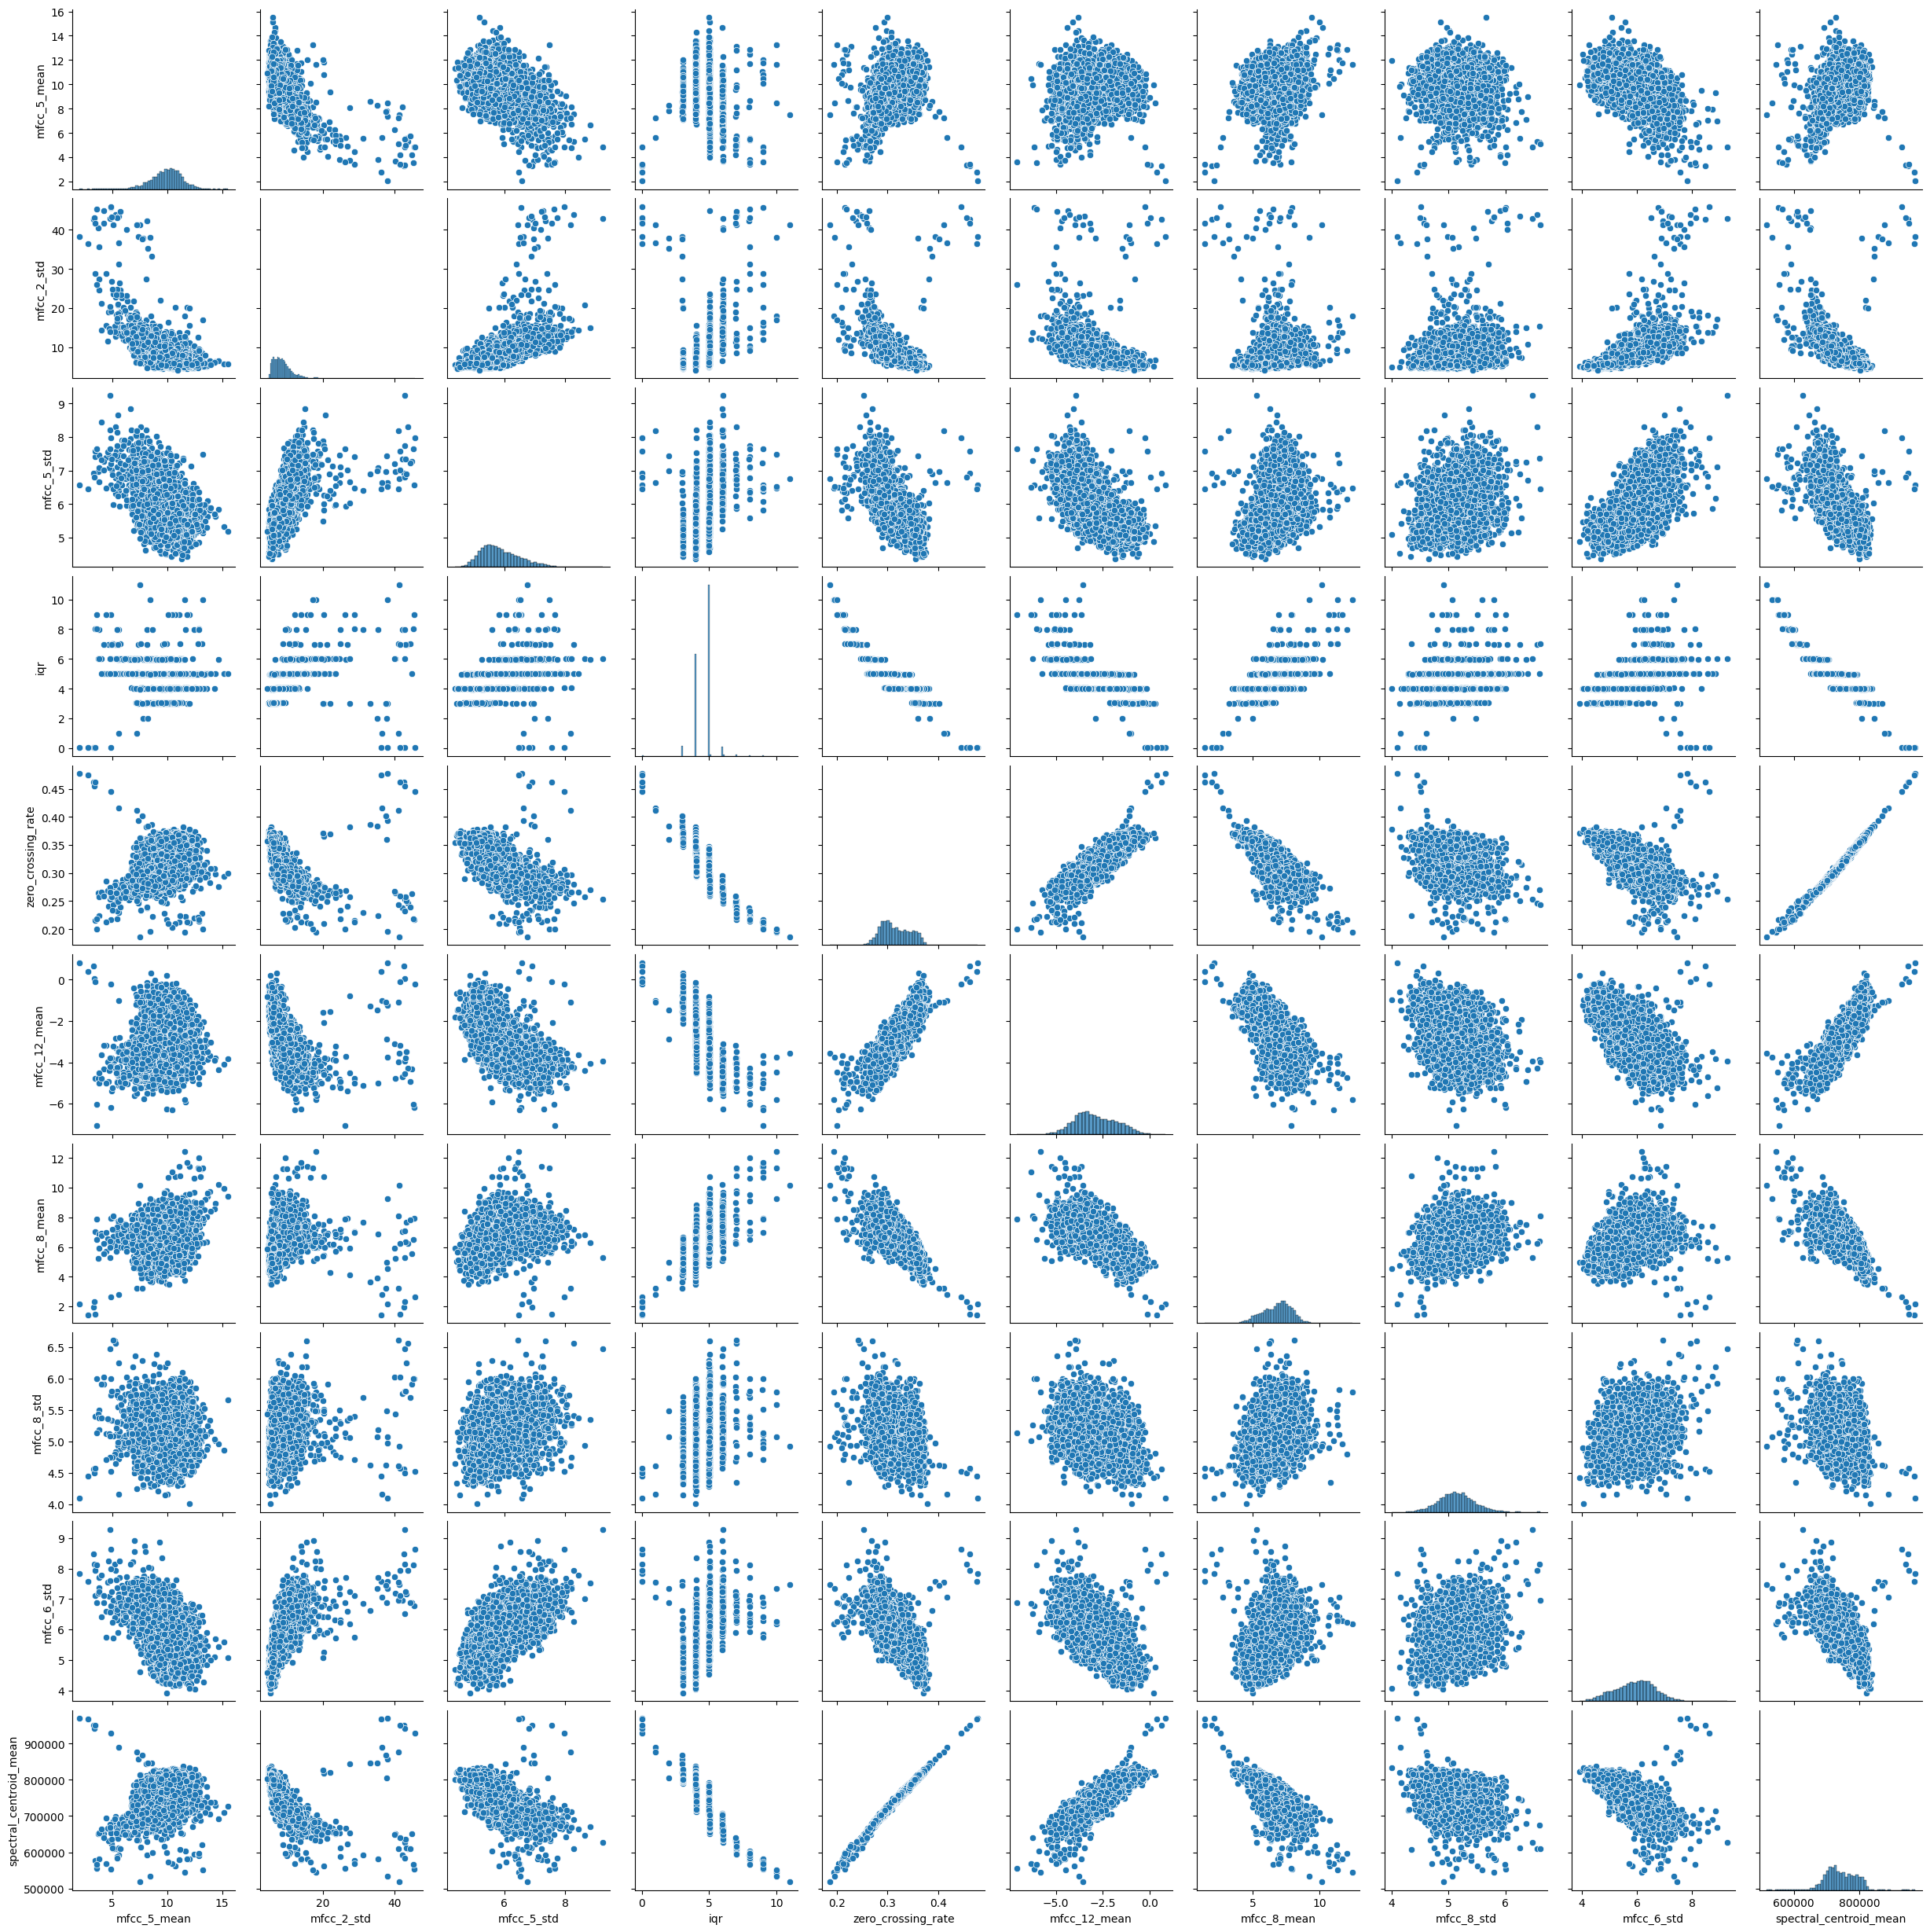

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

print("Seaborn Pairplot을 그리는 중....")
sns.pairplot(Top_10_features)
plt.show()

## --- 모델 설계 ---

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 3151, number of used features: 5
[LightGBM] [Info] Start training from score 5.687041


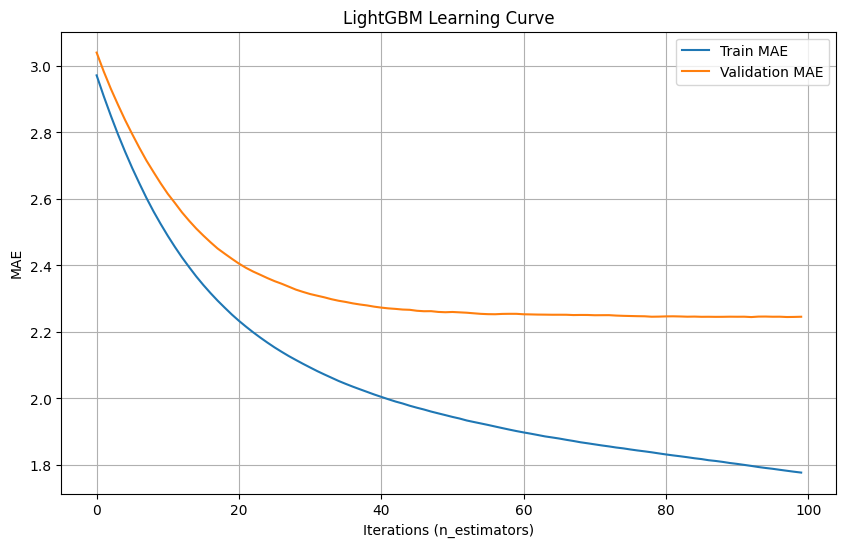

In [30]:
# 과적합

from lightgbm import LGBMRegressor
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

data = pd.read_csv('/kaggle/input/final-data/final_feature.csv')
target = pd.read_csv('/kaggle/input/final-data/final_target.csv')
final_features_li = ['mfcc_5_std', 'iqr', 'mfcc_5_mean', 'mfcc_8_std', 'mfcc_6_std']
final_data = data[final_features_li]

ratio = 0.75
idx = int(np.ceil(len(final_data) * ratio))

# 데이터 분할
train_data = final_data.iloc[:idx]
train_target = target.iloc[:idx]
val_data = final_data.iloc[idx:]
val_target = target.iloc[idx:]

# 모델
model = LGBMRegressor(n_estimators=100, learning_rate=0.04, random_state=42)

model.fit(train_data, train_target, eval_set=[(train_data, train_target), (val_data, val_target)],
         eval_names = ['Train', 'Validation'], eval_metric='mae')

results = model.evals_result_
epochs = len(results['Train']['l1']) # 'l1'은 LightGBM에서 MAE를 뜻합니다.
x_axis = range(0, epochs)

# 4. 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['Train']['l1'], label='Train MAE')
plt.plot(x_axis, results['Validation']['l1'], label='Validation MAE')
plt.legend()
plt.xlabel('Iterations (n_estimators)')
plt.ylabel('MAE')
plt.title('LightGBM Learning Curve')
plt.grid(True)
plt.show()

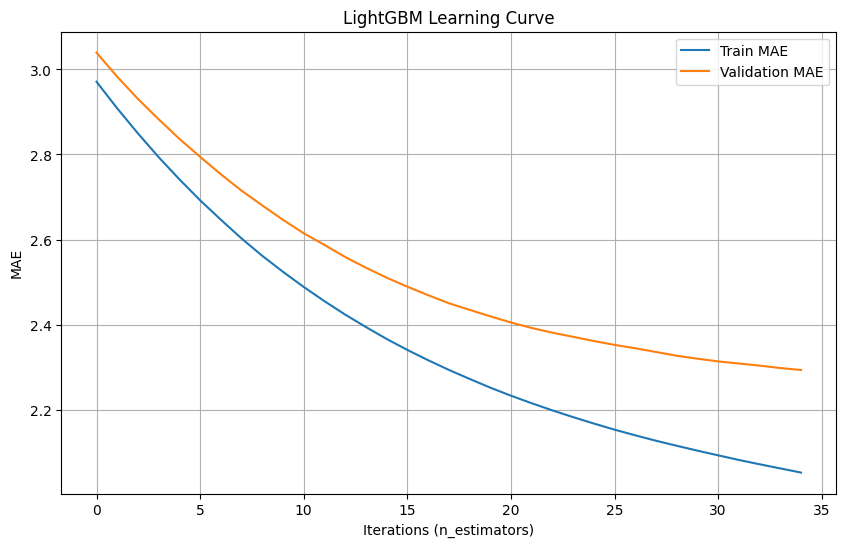

In [27]:
# 과적합

from lightgbm import LGBMRegressor
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

data = pd.read_csv('/kaggle/input/final-data/final_feature.csv')
target = pd.read_csv('/kaggle/input/final-data/final_target.csv')
final_features_li = ['mfcc_5_std', 'iqr', 'mfcc_5_mean', 'mfcc_8_std', 'mfcc_6_std']
final_data = data[final_features_li]

ratio = 0.75
idx = int(np.ceil(len(final_data) * ratio))

# 데이터 분할
train_data = final_data.iloc[:idx]
train_target = target.iloc[:idx]
val_data = final_data.iloc[idx:]
val_target = target.iloc[idx:]

# 모델
model = LGBMRegressor(n_estimators=35, learning_rate=0.04, random_state=42)

model.fit(train_data, train_target, eval_set=[(train_data, train_target), (val_data, val_target)],
         eval_names = ['Train', 'Validation'], eval_metric='mae')

results = model.evals_result_
epochs = len(results['Train']['l1']) # 'l1'은 LightGBM에서 MAE를 뜻합니다.
x_axis = range(0, epochs)

# 4. 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['Train']['l1'], label='Train MAE')
plt.plot(x_axis, results['Validation']['l1'], label='Validation MAE')
plt.legend()
plt.xlabel('Iterations (n_estimators)')
plt.ylabel('MAE')
plt.title('LightGBM Learning Curve')
plt.grid(True)
plt.show()

In [28]:
from lightgbm import LGBMRegressor
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error

data = pd.read_csv('/kaggle/input/final-data/final_feature.csv')
target = pd.read_csv('/kaggle/input/final-data/final_target.csv')
final_features_li = ['mfcc_5_std', 'iqr', 'mfcc_5_mean', 'mfcc_8_std', 'mfcc_6_std']
final_data = data[final_features_li]

# K-Fold 설정
k = 5
sample_size = len(final_data) // k
num_epochs = 100
N_split = 5

for i in range(k):
  print(f"\n--- {i+1}번째 flod ---")
  # 데이터 분할
  val_data = final_data.iloc[i*sample_size : (i+1)*sample_size]
  val_target = target.iloc[i*sample_size : (i+1)*sample_size]
  train_data = np.concatenate([final_data.iloc[:i*sample_size], final_data.iloc[(i+1)*sample_size:]], axis=0)
  train_target = np.concatenate([target.iloc[:i*sample_size], target.iloc[(i+1)*sample_size:]], axis=0)

  # 모델 구현
  model = LGBMRegressor(n_estimators=35, learning_rate=0.04, random_state=i)
  model.fit(train_data, train_target)

  # 검증 데이터 예측
  prediction = model.predict(val_data)

  mae = mean_absolute_error(val_target, prediction)
  print("Mean Absolute Error : ", mae)


--- 1번째 flod ---
Mean Absolute Error :  2.25059775849432

--- 2번째 flod ---
Mean Absolute Error :  2.551497729496047

--- 3번째 flod ---
Mean Absolute Error :  2.4457994476992932

--- 4번째 flod ---
Mean Absolute Error :  1.5011806243445502

--- 5번째 flod ---
Mean Absolute Error :  2.4555502179071698


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

## --- LSTM ---

### 0. Features

In [ ]:
import pandas as pd
import numpy as np
import librosa
from scipy import fft, signal as sg
import glob

file_paths = r'/content/drive/MyDrive/Colab Notebooks/train/*.csv'

files = sorted(glob.glob(file_paths))
files.reverse()

def create_lstm_features(segment_signal, time_steps=150):
  step_length = len(segment_signal) // time_steps
  lstm_features = []

  for i in range(time_steps):
    start = i * step_length
    end = start + step_length
    sub_signal = segment_signal[start:end]

    #Spectral centroid
    data_normalized = sub_signal.astype(np.float32)
    if np.max(np.abs(data_normalized)) > 0:
      data_normalized = data_normalized / np.max(np.abs(data_normalized))
    spectral_cent = librosa.feature.spectral_centroid(y=data_normalized, sr=4000000, n_fft=256)[0]
    spectral_roll = librosa.feature.spectral_rolloff(y=data_normalized, sr=4000000, n_fft=256)[0]
    # FFT
    fft_values = np.abs(fft.fft(sub_signal))
    fft_values = fft_values[:len(fft_values) // 2]

    #Signal
    zero_crossings = np.where(np.diff(np.sign(sub_signal)))[0]
    peaks, properties = sg.find_peaks(sub_signal, height=0)
    neg_peaks, neg_properties = sg.find_peaks(-sub_signal, height=0)

    step_features = [
        np.mean(sub_signal),
        np.std(sub_signal),
        np.min(sub_signal),
        np.max(sub_signal),
        np.median(sub_signal),
        np.mean(spectral_cent),
        np.std(spectral_cent),
        np.min(spectral_cent),
        np.max(spectral_cent),
        np.median(spectral_cent),
        np.mean(spectral_roll),
        np.std(spectral_roll),
        np.min(spectral_roll),
        np.max(spectral_roll),
        np.median(spectral_roll),
        np.mean(fft_values),
        np.std(fft_values),
        np.min(fft_values),
        np.max(fft_values),
        np.median(fft_values),
        len(zero_crossings)/len(sub_signal),
        len(peaks),
        np.mean(properties['peak_heights']) if len(peaks) > 0 else 0,
        np.max(properties['peak_heights']) if len(peaks) > 0 else 0,
        np.std(properties['peak_heights']) if len(peaks) > 0 else 0,
        len(neg_peaks),
        np.mean(neg_properties['peak_heights']) if len(neg_peaks) > 0 else 0,
        np.max(neg_properties['peak_heights']) if len(neg_peaks) > 0 else 0
    ]
    lstm_features.append(step_features)

  return np.array(lstm_features)

x_train_lstm_li = []
y_train_lstm_li = []

for file_name in files:
  df = pd.read_csv(file_name)
  print(f"--- {file_name} 파일 실행 중 ---")

  for segment in range(len(df), 0, -150_000):
    end_idx = segment
    if segment - 150_000 <= 0:
      padding_df = df['acoustic_data'].iloc[:end_idx]
      padding_size = 150_000 - len(padding_df)
      padding_val = np.mean(padding_df)
      padded_segment = np.concatenate([np.full(padding_size, padding_val), padding_df])
    else:
      padded_segment = df['acoustic_data'].iloc[segment - 150_000 : end_idx].values

    noise = np.random.normal(0, 0.01, len(padded_segment))
    signal = padded_segment.astype(float)
    signal -= np.median(signal)
    signal += noise

    sequence_features = create_lstm_features(signal)


    x_train_lstm_li.append(sequence_features)
    y_train_lstm_li.append(df['time_to_failure'].iloc[end_idx - 1])

x_train_lstm = np.array(x_train_lstm_li)
y_train_lstm = np.array(y_train_lstm_li)

print(x_train_lstm.shape)
print(y_train_lstm.shape)

In [ ]:
print("--- 데이터 뒤바꾸기 ---")
x_train_lstm_re = x_train_lstm[::-1]
y_train_lstm_re = y_train_lstm[::-1]
print("--- 데이터 저장 ---")
np.savez('lstm_dataset_final.npz', x_data=x_train_lstm_re, y_data=y_train_lstm_re)
print("--- 저장 완료!! ---")

In [31]:
import numpy as np

data = np.load('/kaggle/input/final-data/lstm_dataset_final.npz')

x_data = data['x_data']
y_data = data['y_data']
x_data.shape

(4201, 150, 28)

### --- LSTM 작성 ---

### 1. 단방향 & many to one

In [25]:
import pandas as pd
from keras.models import Model
from keras.layers import Input, Dense, LSTM
from keras.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# 위의 파일을 다 하면 따로 저장한후  불러오기
data = np.load('/kaggle/input/final-data/lstm_dataset_final.npz')
x_data = data['x_data']
y_data = data['y_data']

k = 5
num_val_samples = len(x_data) // k
num_epochs = 100

for i in range(k):
  print(f"--- {i+1}Fold 실행 중 ---")

  # 데이터 분할
  val_data = x_data[i * num_val_samples : (i+1) * num_val_samples]
  val_target = y_data[i * num_val_samples : (i+1) * num_val_samples]
  train_data = np.concatenate([x_data[:i * num_val_samples], x_data[(i+1) * num_val_samples:]], axis=0)
  train_target = np.concatenate([y_data[:i * num_val_samples], y_data[(i+1) * num_val_samples:]], axis=0)

  # 모델 구현
  uni_input = Input(shape=x_data.shape[1:])
  uni_lstm_1 = LSTM(32, return_sequences=True)(uni_input)
  uni_lstm_2 = LSTM(16, return_sequences=True)(uni_lstm_1)
  uni_lstm_3 = LSTM(8)(uni_lstm_2)
  uni_output = Dense(1)(uni_lstm_3)

  model = Model(uni_input, uni_output)
  model.compile(loss='mae', optimizer="adam")

  # 학습
  model.fit(train_data, train_target, epochs = num_epochs, batch_size=128,
                      verbose=0, shuffle=False)
  prediction = model.predict(val_data)
  prediction_flat = prediction.flatten() # AI를 이용해 고침 다른 사이트 찾아보기

  #mae 구하기
  mae = mean_absolute_error(val_target, prediction_flat)
  print("Mean Absolute Error : ", mae)
  print(f"--- {i+1} Fold 처리 끝 --- \n")

# plt.figure(figsize=(12, 6))
# plt.plot(model.history.history['loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
# plt.show()

--- 1Fold 실행 중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Mean Absolute Error :  tf.Tensor(3.1199846, shape=(), dtype=float32)
--- 1 Fold 처리 끝 --- 

--- 2Fold 실행 중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Mean Absolute Error :  tf.Tensor(3.2176845, shape=(), dtype=float32)
--- 2 Fold 처리 끝 --- 

--- 3Fold 실행 중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Mean Absolute Error :  tf.Tensor(3.1070867, shape=(), dtype=float32)
--- 3 Fold 처리 끝 --- 

--- 4Fold 실행 중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Mean Absolute Error :  tf.Tensor(2.6008916, shape=(), dtype=float32)
--- 4 Fold 처리 끝 --- 

--- 5Fold 실행 중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Mean Absolute Error :  tf.Tensor(3.2652695, shape=(), dtype=float32)
--- 5 Fold 처리 끝 --- 



### -- 정규화 후 --

In [5]:
import pandas as pd
from keras.models import Model
from keras.layers import Input, Dense, LSTM
from keras.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np

data = np.load('/kaggle/input/final-data/lstm_dataset_final.npz')
x_data = data['x_data']
y_data = data['y_data']

k = 5
num_val_samples = len(x_data) // k
num_epochs = 100

for i in range(k):
    print(f"--- {i+1}Fold 실행 중 ---")
    # 데이터 분할
    val_data = x_data[i * num_val_samples : (i+1) * num_val_samples]
    val_target = y_data[i * num_val_samples : (i+1) * num_val_samples]
    train_data = np.concatenate([x_data[:i * num_val_samples], x_data[(i+1) * num_val_samples:]], axis=0)
    train_target = np.concatenate([y_data[:i * num_val_samples], y_data[(i+1) * num_val_samples:]], axis=0)
    
    # 정규화
    scaler = MinMaxScaler()
    train_data_scaled = scaler.fit_transform(train_data.reshape(-1, train_data.shape[-1])).reshape(train_data.shape)
    val_data_scaled = scaler.transform(val_data.reshape(-1, val_data.shape[-1])).reshape(val_data.shape)
    
    # 모델 구현
    uni_input = Input(shape=x_data.shape[1:])
    uni_lstm_1 = LSTM(32, return_sequences=True)(uni_input)
    uni_lstm_2 = LSTM(16, return_sequences=True)(uni_lstm_1)
    uni_lstm_3 = LSTM(8)(uni_lstm_2)
    uni_output = Dense(1)(uni_lstm_3)
    
    model = Model(uni_input, uni_output)
    model.compile(loss='mae', optimizer="adam")
    
    # 학습
    model.fit(train_data_scaled, train_target, epochs = num_epochs, batch_size=128,
                      verbose=0, shuffle=False)
    prediction = model.predict(val_data_scaled)
    prediction_flat = prediction.flatten()
    
    #mae 구하기
    mae = mean_absolute_error(val_target, prediction_flat)
    print("Mean Absolute Error : ", mae)
    print(f"--- {i+1} Fold 처리 끝 --- \n")

--- 1Fold 실행 중 ---


I0000 00:00:1763973873.640751     113 cuda_dnn.cc:529] Loaded cuDNN version 90300


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Mean Absolute Error :  tf.Tensor(2.9472406, shape=(), dtype=float32)
--- 1 Fold 처리 끝 --- 

--- 2Fold 실행 중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Mean Absolute Error :  tf.Tensor(3.2181103, shape=(), dtype=float32)
--- 2 Fold 처리 끝 --- 

--- 3Fold 실행 중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Mean Absolute Error :  tf.Tensor(2.471689, shape=(), dtype=float32)
--- 3 Fold 처리 끝 --- 

--- 4Fold 실행 중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Mean Absolute Error :  tf.Tensor(2.579915, shape=(), dtype=float32)
--- 4 Fold 처리 끝 --- 

--- 5Fold 실행 중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Mean Absolute Error :  tf.Tensor(3.0769749, shape=(), dtype=float32)
--- 5 Fold 처리 끝 --- 



평균적인 MAE : 2.859

### 2. 양방향 & many to one

In [27]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Bidirectional
import numpy as np

data = np.load('/kaggle/input/final-data/lstm_dataset_final.npz')
x_data = data['x_data']
y_data = data['y_data']

k = 5
num_val_samples = len(x_data) // k
num_epochs = 100

# K-Fold 실행
for i in range(k):
    print(f"--- {i+1}FOLD 처리중 ---")

    val_data = x_data[i * num_val_samples : (i+1) * num_val_samples]
    val_target= y_data[i * num_val_samples : (i+1) * num_val_samples]
    
    train_data = np.concatenate([x_data[:i * num_val_samples], x_data[(i+1)*num_val_samples:]], axis=0)
    train_target = np.concatenate([y_data[:i * num_val_samples], y_data[(i+1)*num_val_samples:]], axis=0)

    # 양방향 모델 구현
    x_input = Input(shape=x_data.shape[1:])
    bi_lstm_1 = Bidirectional(LSTM(32, return_sequences=True))(x_input)
    bi_lstm_2 = Bidirectional(LSTM(16, return_sequences=True))(bi_lstm_1)
    bi_lstm_3 = Bidirectional(LSTM(8))(bi_lstm_2)
    output = Dense(1)(bi_lstm_3)
    
    model = Model(x_input, output)
    model.compile(loss='mae', optimizer='adam')
    
    # 학습
    model.fit(train_data, train_target, batch_size=128, epochs=num_epochs, verbose=0, shuffle=False)
    #검증 데이터
    prediction = model.predict(val_data)
    prediction_flat = prediction.flatten()
    
    mae = mean_absolute_error(val_target, prediction_flat)
    print("Mean_Absolute_Error :", mae)
    print(f"--- {i+1} Fold 처리 끝 ---\n")

--- 1FOLD 처리중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Mean_Absolute_Error : tf.Tensor(3.1106567, shape=(), dtype=float32)
--- 1 Fold 처리 끝 ---

--- 2FOLD 처리중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Mean_Absolute_Error : tf.Tensor(3.210864, shape=(), dtype=float32)
--- 2 Fold 처리 끝 ---

--- 3FOLD 처리중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Mean_Absolute_Error : tf.Tensor(3.1007314, shape=(), dtype=float32)
--- 3 Fold 처리 끝 ---

--- 4FOLD 처리중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Mean_Absolute_Error : tf.Tensor(2.5720286, shape=(), dtype=float32)
--- 4 Fold 처리 끝 ---

--- 5FOLD 처리중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Mean_Absolute_Error : tf.Tensor(3.2313685, shape=(), dtype=float32)
--- 5 Fold 처리 끝 ---



### 정규화 후

In [6]:
import pandas as pd
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Bidirectional
from keras.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# data = np.load('/kaggle/input/final-data/lstm_dataset_final.npz')
# x_data = data['x_data']
# y_data = data['y_data']

k=5
num_val_samples = len(x_data) // k
num_epochs = 100

for i in range(k):
    print(f"--- {i+1}FOLD 처리중 ---")

    val_data = x_data[i * num_val_samples : (i+1) * num_val_samples]
    val_target= y_data[i * num_val_samples : (i+1) * num_val_samples]
    
    train_data = np.concatenate([x_data[:i * num_val_samples], x_data[(i+1)*num_val_samples:]], axis=0)
    train_target = np.concatenate([y_data[:i * num_val_samples], y_data[(i+1)*num_val_samples:]], axis=0)

    # 정규화
    scaler = MinMaxScaler()
    train_data_scaled = scaler.fit_transform(train_data.reshape(-1, train_data.shape[-1])).reshape(train_data.shape)
    val_data_scaled = scaler.transform(val_data.reshape(-1, val_data.shape[-1])).reshape(val_data.shape)

    # 양방향 모델 구현
    x_input = Input(shape=x_data.shape[1:])
    bi_lstm_1 = Bidirectional(LSTM(32, return_sequences=True))(x_input)
    bi_lstm_2 = Bidirectional(LSTM(16, return_sequences=True))(bi_lstm_1)
    bi_lstm_3 = Bidirectional(LSTM(8))(bi_lstm_2)
    output = Dense(1)(bi_lstm_3)
    
    model = Model(x_input, output)
    model.compile(loss='mae', optimizer='adam')
    
    # 학습
    model.fit(train_data_scaled, train_target, batch_size=128, epochs=num_epochs, verbose=0, shuffle=False)
    #검증 데이터
    prediction = model.predict(val_data_scaled)
    prediction_flat = prediction.flatten()
    
    mae = mean_absolute_error(val_target, prediction_flat)
    print("Mean_Absolute_Error :", mae)
    print(f"--- {i+1} Fold 처리 끝 ---\n")

--- 1FOLD 처리중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Mean_Absolute_Error : tf.Tensor(2.2253883, shape=(), dtype=float32)
--- 1 Fold 처리 끝 ---

--- 2FOLD 처리중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Mean_Absolute_Error : tf.Tensor(2.226751, shape=(), dtype=float32)
--- 2 Fold 처리 끝 ---

--- 3FOLD 처리중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Mean_Absolute_Error : tf.Tensor(2.4619477, shape=(), dtype=float32)
--- 3 Fold 처리 끝 ---

--- 4FOLD 처리중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Mean_Absolute_Error : tf.Tensor(1.6489326, shape=(), dtype=float32)
--- 4 Fold 처리 끝 ---

--- 5FOLD 처리중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Mean_Absolute_Error : tf.Tensor(2.4650776, shape=(), dtype=float32)
--- 5 Fold 처리 끝 ---



평균 MAE : 2.206

### 3. 단방향 2개 & 양방향 1개

In [33]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Bidirectional
from keras.metrics import mean_absolute_error
import numpy as np

# data = np.load('/content/drive/MyDrive/Colab Notebooks/lstm_dataset_final.npz')
# x_data = data['x_data']
# y_data = data['y_data']

k = 5
num_val_samples = len(x_data) // k
num_epochs = 100

# K-Fold 준비
k = 5
num_epochs = 100
num_val_size = len(x_data) // k

# K-Fold 실행
for i in range(k):
  print(f"--- {i+1}번째 FOLD 실행 중 ---")
  val_data = x_data[i*num_val_size : (i+1)*num_val_size]
  val_target = y_data[i*num_val_size : (i+1)*num_val_size]

  train_data = np.concatenate([x_data[:i*num_val_size], x_data[(i+1)*num_val_size:]], axis=0)
  train_target = np.concatenate([y_data[:i*num_val_size], y_data[(i+1)*num_val_size:]],axis=0)

  # 모델 구현
  x_input = Input(shape=x_data.shape[1:])
  uni_lstm_1 = LSTM(32, return_sequences=True)(x_input)
  uni_lstm_2 = LSTM(16, return_sequences=True)(uni_lstm_1)
  bi_lstm_1 = Bidirectional(LSTM(8))(uni_lstm_2)
  output = Dense(1)(bi_lstm_1)

  model = Model(x_input, output)
  model.compile(loss='mae', optimizer='adam')

  # 학습
  model.fit(train_data, train_target, batch_size=128, epochs=num_epochs,
            verbose=0, shuffle=False)
  # 예측
  prediction = model.predict(val_data)
  prediction_flat = prediction.flatten()

  # mae 구하기
  mae = mean_absolute_error(val_target, prediction_flat)
  print("Mean Absolute Error : ", mae)
  print(f"--- {i+1} Fold 처리 끝 ---\n")

--- 1번째 FOLD 실행 중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Mean Absolute Error :  tf.Tensor(3.1167183, shape=(), dtype=float32)
--- 1 Fold 처리 끝 ---

--- 2번째 FOLD 실행 중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Mean Absolute Error :  tf.Tensor(3.064634, shape=(), dtype=float32)
--- 2 Fold 처리 끝 ---

--- 3번째 FOLD 실행 중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Mean Absolute Error :  tf.Tensor(3.0076332, shape=(), dtype=float32)
--- 3 Fold 처리 끝 ---

--- 4번째 FOLD 실행 중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Mean Absolute Error :  tf.Tensor(2.6008677, shape=(), dtype=float32)
--- 4 Fold 처리 끝 ---

--- 5번째 FOLD 실행 중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Mean Absolute Error :  tf.Tensor(3.2511044, shape=(), dtype=float32)
--- 5 Fold 처리 끝 ---



### 정규화 후

In [7]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM
from keras.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# data = np.load('/content/drive/MyDrive/Colab Notebooks/lstm_dataset_final.npz')
# x_data = data['x_data']
# y_data = data['y_data']

# K-Fold 준비
k = 5
num_epochs = 100
num_val_size = len(x_data) // k

# K-Fold 실행
for i in range(k):
    print(f"--- {i+1}번째 FOLD 실행 중 ---")
    val_data = x_data[i*num_val_size : (i+1)*num_val_size]
    val_target = y_data[i*num_val_size : (i+1)*num_val_size]
    
    train_data = np.concatenate([x_data[:i*num_val_size], x_data[(i+1)*num_val_size:]], axis=0)
    train_target = np.concatenate([y_data[:i*num_val_size], y_data[(i+1)*num_val_size:]],axis=0)
    
    # 정규화
    scaler = MinMaxScaler()
    train_data_scaled = scaler.fit_transform(train_data.reshape(-1, train_data.shape[-1])).reshape(train_data.shape)
    val_data_scaled = scaler.transform(val_data.reshape(-1, val_data.shape[-1])).reshape(val_data.shape)
    
    # 모델 구현
    x_input = Input(shape=x_data.shape[1:])
    uni_lstm_1 = LSTM(32, return_sequences=True)(x_input)
    uni_lstm_2 = LSTM(16, return_sequences=True)(uni_lstm_1)
    bi_lstm_1 = Bidirectional(LSTM(8))(uni_lstm_2)
    output = Dense(1)(bi_lstm_1)
    
    model = Model(x_input, output)
    model.compile(loss='mae', optimizer='adam')
    
    # 학습
    model.fit(train_data_scaled, train_target, batch_size=128, epochs=num_epochs,
            verbose=0, shuffle=False)
    # 예측
    prediction = model.predict(val_data_scaled)
    prediction_flat = prediction.flatten()
    
    # mae 구하기
    mae = mean_absolute_error(val_target, prediction_flat)
    print("Mean Absolute Error : ", mae)
    print(f"--- {i+1} Fold 처리 끝 ---\n")

--- 1번째 FOLD 실행 중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Mean Absolute Error :  tf.Tensor(2.1799886, shape=(), dtype=float32)
--- 1 Fold 처리 끝 ---

--- 2번째 FOLD 실행 중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Mean Absolute Error :  tf.Tensor(2.2914903, shape=(), dtype=float32)
--- 2 Fold 처리 끝 ---

--- 3번째 FOLD 실행 중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Mean Absolute Error :  tf.Tensor(2.5164392, shape=(), dtype=float32)
--- 3 Fold 처리 끝 ---

--- 4번째 FOLD 실행 중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Mean Absolute Error :  tf.Tensor(1.5544201, shape=(), dtype=float32)
--- 4 Fold 처리 끝 ---

--- 5번째 FOLD 실행 중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Mean Absolute Error :  tf.Tensor(2.4846518, shape=(), dtype=float32)
--- 5 Fold 처리 끝 ---



평균 MAE : 2.205

### 4. 단방향 1개 & 양방향 2개

In [35]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Bidirectional
from keras.metrics import mean_absolute_error
import numpy as np

# data = np.load('/content/drive/MyDrive/Colab Notebooks/lstm_dataset_final.npz')
# x_data = data['x_data']
# y_data = data['y_data']

k = 5
num_val_samples = len(x_data) // k
num_epochs = 100

# K-Fold 준비
k = 5
num_epochs = 100
num_val_size = len(x_data) // k

# K-Fold 실행
for i in range(k):
  print(f"--- {i+1}번째 FOLD 실행 중 ---")
  val_data = x_data[i*num_val_size : (i+1)*num_val_size]
  val_target = y_data[i*num_val_size : (i+1)*num_val_size]

  train_data = np.concatenate([x_data[:i*num_val_size], x_data[(i+1)*num_val_size:]], axis=0)
  train_target = np.concatenate([y_data[:i*num_val_size], y_data[(i+1)*num_val_size:]],axis=0)

  # 모델 구현
  x_input = Input(shape=x_data.shape[1:])
  uni_lstm_1 = LSTM(32, return_sequences=True)(x_input)
  bi_lstm_1 = Bidirectional(LSTM(16, return_sequences=True))(uni_lstm_1)
  bi_lstm_2 = Bidirectional(LSTM(8))(bi_lstm_1)
  output = Dense(1)(bi_lstm_2)

  model = Model(x_input, output)
  model.compile(loss='mae', optimizer='adam')

  # 학습
  model.fit(train_data, train_target, batch_size=128, epochs=num_epochs,
            verbose=0, shuffle=False)
  # 예측
  prediction = model.predict(val_data)
  prediction_flat = prediction.flatten()

  # mae 구하기
  mae = mean_absolute_error(val_target, prediction_flat)
  print("Mean Absolute Error : ", mae)
  print(f"--- {i+1} Fold 처리 끝 ---\n")

--- 1번째 FOLD 실행 중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Mean Absolute Error :  tf.Tensor(3.1190708, shape=(), dtype=float32)
--- 1 Fold 처리 끝 ---

--- 2번째 FOLD 실행 중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Mean Absolute Error :  tf.Tensor(3.1799965, shape=(), dtype=float32)
--- 2 Fold 처리 끝 ---

--- 3번째 FOLD 실행 중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Mean Absolute Error :  tf.Tensor(3.1054833, shape=(), dtype=float32)
--- 3 Fold 처리 끝 ---

--- 4번째 FOLD 실행 중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Mean Absolute Error :  tf.Tensor(2.5564876, shape=(), dtype=float32)
--- 4 Fold 처리 끝 ---

--- 5번째 FOLD 실행 중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Mean Absolute Error :  tf.Tensor(3.250422, shape=(), dtype=float32)
--- 5 Fold 처리 끝 ---



### 정규화 후

In [9]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM
from keras.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# data = np.load('/content/drive/MyDrive/Colab Notebooks/lstm_dataset_final.npz')
# x_data = data['x_data']
# y_data = data['y_data']

k = 5
num_val_samples = len(x_data) // k
num_epochs = 100

# K-Fold 준비
k = 5
num_epochs = 100
num_val_size = len(x_data) // k

# K-Fold 실행
for i in range(k):
    print(f"--- {i+1}번째 FOLD 실행 중 ---")
    val_data = x_data_scaled[i*num_val_size : (i+1)*num_val_size]
    val_target = y_data[i*num_val_size : (i+1)*num_val_size]
    
    train_data = np.concatenate([x_data_scaled[:i*num_val_size], x_data_scaled[(i+1)*num_val_size:]], axis=0)
    train_target = np.concatenate([y_data[:i*num_val_size], y_data[(i+1)*num_val_size:]],axis=0)
    
    # 정규화
    scaler = MinMaxScaler()
    train_data_scaled = scaler.fit_transform(train_data.reshape(-1, train_data.shape[-1])).reshape(train_data.shape)
    val_data_scaled = scaler.transform(val_data.reshape(-1, val_data.shape[-1])).reshape(val_data.shape)
    
    # 모델 구현
    x_input = Input(shape=x_data.shape[1:])
    uni_lstm_1 = LSTM(32, return_sequences=True)(x_input)
    bi_lstm_1 = Bidirectional(LSTM(16, return_sequences=True))(uni_lstm_1)
    bi_lstm_2 = Bidirectional(LSTM(8))(bi_lstm_1)
    output = Dense(1)(bi_lstm_2)
    
    model = Model(x_input, output)
    model.compile(loss='mae', optimizer='adam')
    
    # 학습
    model.fit(train_data_scaled, train_target, batch_size=128, epochs=num_epochs,
            verbose=0, shuffle=False)
    # 예측
    prediction = model.predict(val_data_scaled)
    prediction_flat = prediction.flatten()
    
    # mae 구하기
    mae = mean_absolute_error(val_target, prediction_flat)
    print("Mean Absolute Error : ", mae)
    print(f"--- {i+1} Fold 처리 끝 ---\n")

--- 1번째 FOLD 실행 중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Mean Absolute Error :  tf.Tensor(2.7652657, shape=(), dtype=float32)
--- 1 Fold 처리 끝 ---

--- 2번째 FOLD 실행 중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Mean Absolute Error :  tf.Tensor(3.1935098, shape=(), dtype=float32)
--- 2 Fold 처리 끝 ---

--- 3번째 FOLD 실행 중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
Mean Absolute Error :  tf.Tensor(2.4986687, shape=(), dtype=float32)
--- 3 Fold 처리 끝 ---

--- 4번째 FOLD 실행 중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Mean Absolute Error :  tf.Tensor(1.5833446, shape=(), dtype=float32)
--- 4 Fold 처리 끝 ---

--- 5번째 FOLD 실행 중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Mean Absolute Error :  tf.Tensor(3.2129998, shape=(), dtype=float32)
--- 5 Fold 처리 끝 ---



평균 MAE : 2.65

### 5. 단방향 2개 & 양방향 2개

In [37]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Bidirectional
from keras.metrics import mean_absolute_error
import numpy as np

# data = np.load('/content/drive/MyDrive/Colab Notebooks/lstm_dataset_final.npz')
# x_data = data['x_data']
# y_data = data['y_data']

# K-Fold 준비
k = 5
num_epochs = 100
num_val_size = len(x_data) // k

# K-Fold 실행
for i in range(k):
  print(f"--- {i+1}번째 FOLD 실행 중 ---")
  val_data = x_data[i*num_val_size : (i+1)*num_val_size]
  val_target = y_data[i*num_val_size : (i+1)*num_val_size]

  train_data = np.concatenate([x_data[:i*num_val_size], x_data[(i+1)*num_val_size:]], axis=0)
  train_target = np.concatenate([y_data[:i*num_val_size], y_data[(i+1)*num_val_size:]],axis=0)

  # 모델 구현
  x_input = Input(shape=x_data.shape[1:])
  uni_lstm_1 = LSTM(64, return_sequences=True)(x_input)
  uni_lstm_2 = LSTM(32, return_sequences=True)(uni_lstm_1)
  bi_lstm_1 = Bidirectional(LSTM(16, return_sequences=True))(uni_lstm_2)
  bi_lstm_2 = Bidirectional(LSTM(8))(bi_lstm_1)
  output = Dense(1)(bi_lstm_2)

  model = Model(x_input, output)
  model.compile(loss='mae', optimizer='adam')

  # 학습
  model.fit(train_data, train_target, batch_size=128, epochs=num_epochs,
            verbose=0, shuffle=False)
  # 예측
  prediction = model.predict(val_data)
  prediction_flat = prediction.flatten()

  # mae 구하기
  mae = mean_absolute_error(val_target, prediction_flat)
  print("Mean Absolute Error : ", mae)
  print(f"--- {i+1} Fold 처리 끝 ---\n")

--- 1번째 FOLD 실행 중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Mean Absolute Error :  tf.Tensor(3.1194758, shape=(), dtype=float32)
--- 1 Fold 처리 끝 ---

--- 2번째 FOLD 실행 중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Mean Absolute Error :  tf.Tensor(3.2197027, shape=(), dtype=float32)
--- 2 Fold 처리 끝 ---

--- 3번째 FOLD 실행 중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Mean Absolute Error :  tf.Tensor(3.1063712, shape=(), dtype=float32)
--- 3 Fold 처리 끝 ---

--- 4번째 FOLD 실행 중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Mean Absolute Error :  tf.Tensor(2.6007836, shape=(), dtype=float32)
--- 4 Fold 처리 끝 ---

--- 5번째 FOLD 실행 중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Mean Absolute Error :  tf.Tensor(3.2433634, shape=(), dtype=float32)
--- 5 Fold 처리 끝 ---



### 정규화 후

In [10]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM
from keras.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# data = np.load('/content/drive/MyDrive/Colab Notebooks/lstm_dataset_final.npz')
# x_data = data['x_data']
# y_data = data['y_data']

# K-Fold 준비
k = 5
num_epochs = 100
num_val_size = len(x_data) // k

# K-Fold 실행
for i in range(k):
    print(f"--- {i+1}번째 FOLD 실행 중 ---")
    val_data = x_data[i*num_val_size : (i+1)*num_val_size]
    val_target = y_data[i*num_val_size : (i+1)*num_val_size]
    
    train_data = np.concatenate([x_data[:i*num_val_size], x_data[(i+1)*num_val_size:]], axis=0)
    train_target = np.concatenate([y_data[:i*num_val_size], y_data[(i+1)*num_val_size:]],axis=0)
    
    # 정규화
    scaler = MinMaxScaler()
    train_data_scaled = scaler.fit_transform(train_data.reshape(-1, train_data.shape[-1])).reshape(train_data.shape)
    val_data_scaled = scaler.transform(val_data.reshape(-1, val_data.shape[-1])).reshape(val_data.shape)
    
    # 모델 구현
    x_input = Input(shape=x_data.shape[1:])
    uni_lstm_1 = LSTM(64, return_sequences=True)(x_input)
    uni_lstm_2 = LSTM(32, return_sequences=True)(uni_lstm_1)
    bi_lstm_1 = Bidirectional(LSTM(16, return_sequences=True))(uni_lstm_2)
    bi_lstm_2 = Bidirectional(LSTM(8))(bi_lstm_1)
    output = Dense(1)(bi_lstm_2)
    
    model = Model(x_input, output)
    model.compile(loss='mae', optimizer='adam')
    
    # 학습
    model.fit(train_data_scaled, train_target, batch_size=128, epochs=num_epochs,
            verbose=0, shuffle=False)
    # 예측
    prediction = model.predict(val_data_scaled)
    prediction_flat = prediction.flatten()
    
    # mae 구하기
    mae = mean_absolute_error(val_target, prediction_flat)
    print("Mean Absolute Error : ", mae)
    print(f"--- {i+1} Fold 처리 끝 ---\n")

--- 1번째 FOLD 실행 중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Mean Absolute Error :  tf.Tensor(2.2005558, shape=(), dtype=float32)
--- 1 Fold 처리 끝 ---

--- 2번째 FOLD 실행 중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Mean Absolute Error :  tf.Tensor(2.217499, shape=(), dtype=float32)
--- 2 Fold 처리 끝 ---

--- 3번째 FOLD 실행 중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Mean Absolute Error :  tf.Tensor(2.56474, shape=(), dtype=float32)
--- 3 Fold 처리 끝 ---

--- 4번째 FOLD 실행 중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Mean Absolute Error :  tf.Tensor(2.5489328, shape=(), dtype=float32)
--- 4 Fold 처리 끝 ---

--- 5번째 FOLD 실행 중 ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Mean Absolute Error :  tf.Tensor(2.46049, shape=(), dtype=float32)
--- 5 Fold 처리 끝 ---



평균 MAE : 2.398

### 과적합 확인

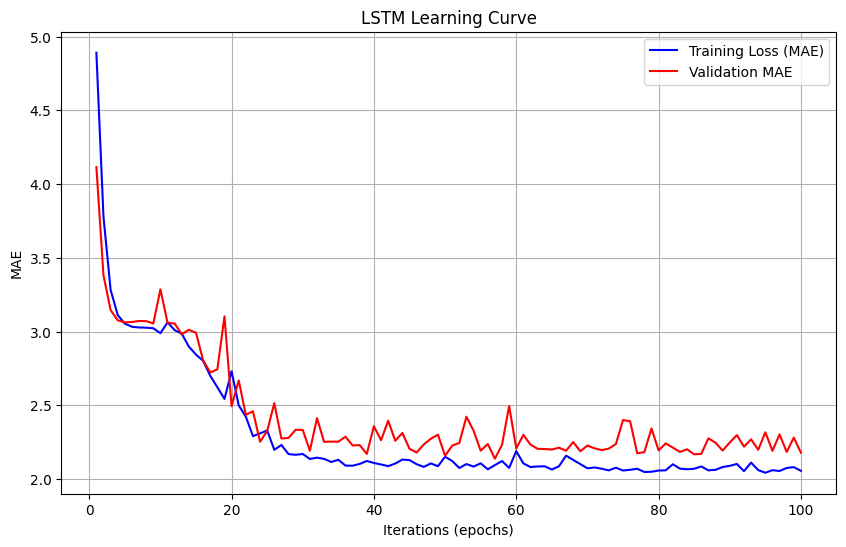

In [11]:
import pandas as pd
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Bidirectional
from keras.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

# 위의 파일을 다 하면 따로 저장한후  불러오기
data = np.load('/kaggle/input/final-data/lstm_dataset_final.npz')
x_data = data['x_data']
y_data = data['y_data']

ratio = 0.75
idx = int(np.ceil(len(x_data) * ratio))

train_data = x_data[:idx]
train_target = y_data[:idx]
val_data = x_data[idx:]
val_target= y_data[idx:]

# 정규화
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data.reshape(-1, train_data.shape[-1])).reshape(train_data.shape)
val_data_scaled = scaler.transform(val_data.reshape(-1, val_data.shape[-1])).reshape(val_data.shape)

# 양방향 모델 구현
x_input = Input(shape=x_data.shape[1:])
bi_lstm_1 = LSTM(32, return_sequences=True)(x_input)
bi_lstm_2 = LSTM(16, return_sequences=True)(bi_lstm_1)
bi_lstm_3 = Bidirectional(LSTM(8))(bi_lstm_2)
output = Dense(1)(bi_lstm_3)

model = Model(x_input, output)
model.compile(loss='mae', optimizer='adam')

# 학습
history = model.fit(train_data_scaled, train_target, batch_size=128, epochs=100, 
                    verbose=0, shuffle=True,
                   validation_data=(val_data_scaled, val_target))

# 학습 기록 가져오기
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'b-', label='Training Loss (MAE)')
plt.plot(epochs, val_loss, 'r-', label='Validation MAE')
plt.legend()
plt.xlabel('Iterations (epochs)')
plt.ylabel('MAE')
plt.title('LSTM Learning Curve')
plt.grid(True)
plt.show()

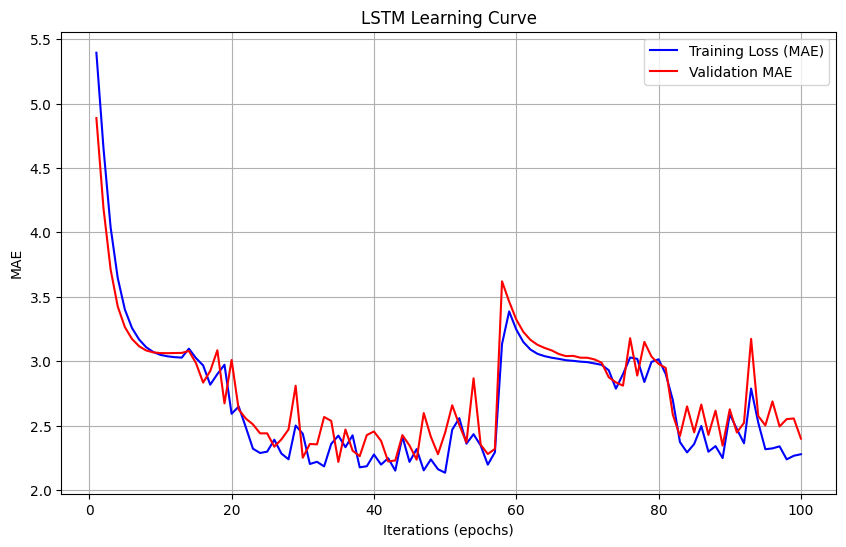

In [15]:
import pandas as pd
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Bidirectional
from keras.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

# 위의 파일을 다 하면 따로 저장한후  불러오기
data = np.load('/kaggle/input/final-data/lstm_dataset_final.npz')
x_data = data['x_data']
y_data = data['y_data']

ratio = 0.75
idx = int(np.ceil(len(x_data) * ratio))

train_data = x_data[:idx]
train_target = y_data[:idx]
val_data = x_data[idx:]
val_target= y_data[idx:]

# 정규화
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data.reshape(-1, train_data.shape[-1])).reshape(train_data.shape)
val_data_scaled = scaler.transform(val_data.reshape(-1, val_data.shape[-1])).reshape(val_data.shape)

# 양방향 모델 구현
x_input = Input(shape=x_data.shape[1:])
bi_lstm_1 = LSTM(32, return_sequences=True)(x_input)
bi_lstm_2 = LSTM(16, return_sequences=True)(bi_lstm_1)
bi_lstm_3 = Bidirectional(LSTM(8))(bi_lstm_2)
output = Dense(1)(bi_lstm_3)

model = Model(x_input, output)
model.compile(loss='mae', optimizer='adam')

# 학습
history = model.fit(train_data_scaled, train_target, batch_size=256, epochs=100, 
                    verbose=0, shuffle=True,
                   validation_data=(val_data_scaled, val_target))

# 학습 기록 가져오기
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'b-', label='Training Loss (MAE)')
plt.plot(epochs, val_loss, 'r-', label='Validation MAE')
plt.legend()
plt.xlabel('Iterations (epochs)')
plt.ylabel('MAE')
plt.title('LSTM Learning Curve')
plt.grid(True)
plt.show()

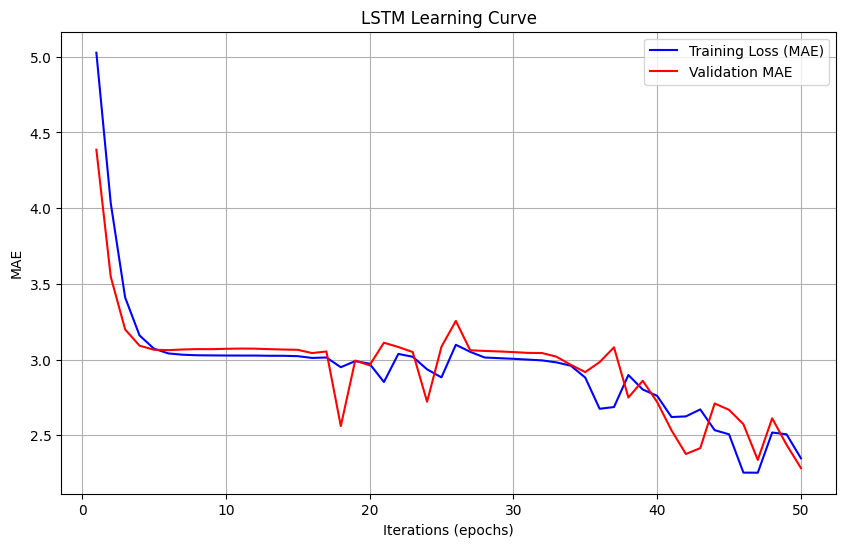

In [24]:
import pandas as pd
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Bidirectional
from keras.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

# 위의 파일을 다 하면 따로 저장한후  불러오기
data = np.load('/kaggle/input/final-data/lstm_dataset_final.npz')
x_data = data['x_data']
y_data = data['y_data']

ratio = 0.75
idx = int(np.ceil(len(x_data) * ratio))

train_data = x_data[:idx]
train_target = y_data[:idx]
val_data = x_data[idx:]
val_target= y_data[idx:]

# 정규화
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data.reshape(-1, train_data.shape[-1])).reshape(train_data.shape)
val_data_scaled = scaler.transform(val_data.reshape(-1, val_data.shape[-1])).reshape(val_data.shape)

# 양방향 모델 구현
x_input = Input(shape=x_data.shape[1:])
bi_lstm_1 = LSTM(32, return_sequences=True)(x_input)
bi_lstm_2 = LSTM(16, return_sequences=True)(bi_lstm_1)
bi_lstm_3 = Bidirectional(LSTM(8))(bi_lstm_2)
output = Dense(1)(bi_lstm_3)

model = Model(x_input, output)
model.compile(loss='mae', optimizer='adam')

# 학습
history = model.fit(train_data_scaled, train_target, batch_size=128, epochs=50, 
                    verbose=0, shuffle=True,
                   validation_data=(val_data_scaled, val_target))

# 학습 기록 가져오기
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'b-', label='Training Loss (MAE)')
plt.plot(epochs, val_loss, 'r-', label='Validation MAE')
plt.legend()
plt.xlabel('Iterations (epochs)')
plt.ylabel('MAE')
plt.title('LSTM Learning Curve')
plt.grid(True)
plt.show()

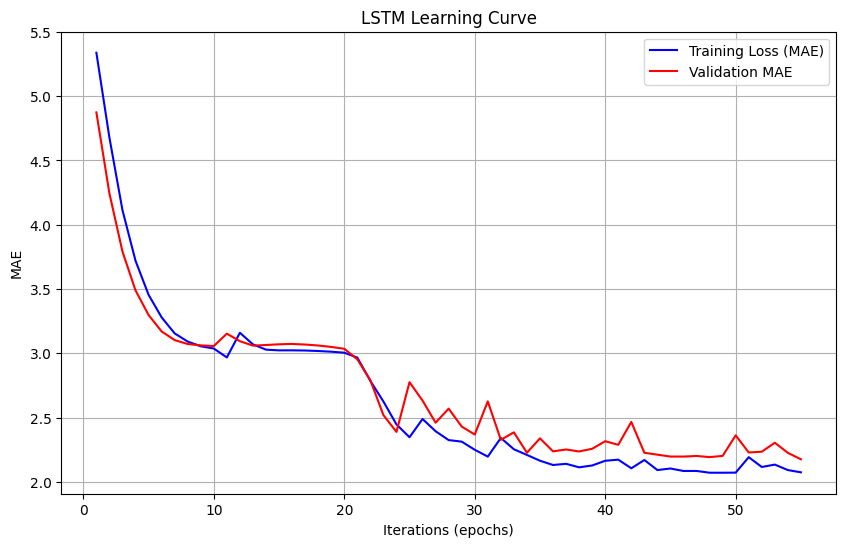

In [23]:
import pandas as pd
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Bidirectional
from keras.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

# 위의 파일을 다 하면 따로 저장한후  불러오기
data = np.load('/kaggle/input/final-data/lstm_dataset_final.npz')
x_data = data['x_data']
y_data = data['y_data']

ratio = 0.75
idx = int(np.ceil(len(x_data) * ratio))

train_data = x_data[:idx]
train_target = y_data[:idx]
val_data = x_data[idx:]
val_target= y_data[idx:]

# 정규화
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data.reshape(-1, train_data.shape[-1])).reshape(train_data.shape)
val_data_scaled = scaler.transform(val_data.reshape(-1, val_data.shape[-1])).reshape(val_data.shape)

# 양방향 모델 구현
x_input = Input(shape=x_data.shape[1:])
bi_lstm_1 = LSTM(32, return_sequences=True)(x_input)
bi_lstm_2 = LSTM(16, return_sequences=True)(bi_lstm_1)
bi_lstm_3 = Bidirectional(LSTM(8))(bi_lstm_2)
output = Dense(1)(bi_lstm_3)

model = Model(x_input, output)
model.compile(loss='mae', optimizer='adam')

# 학습
history = model.fit(train_data_scaled, train_target, batch_size=256, epochs=55, 
                    verbose=0, shuffle=True,
                   validation_data=(val_data_scaled, val_target))

# 학습 기록 가져오기
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'b-', label='Training Loss (MAE)')
plt.plot(epochs, val_loss, 'r-', label='Validation MAE')
plt.legend()
plt.xlabel('Iterations (epochs)')
plt.ylabel('MAE')
plt.title('LSTM Learning Curve')
plt.grid(True)
plt.show()

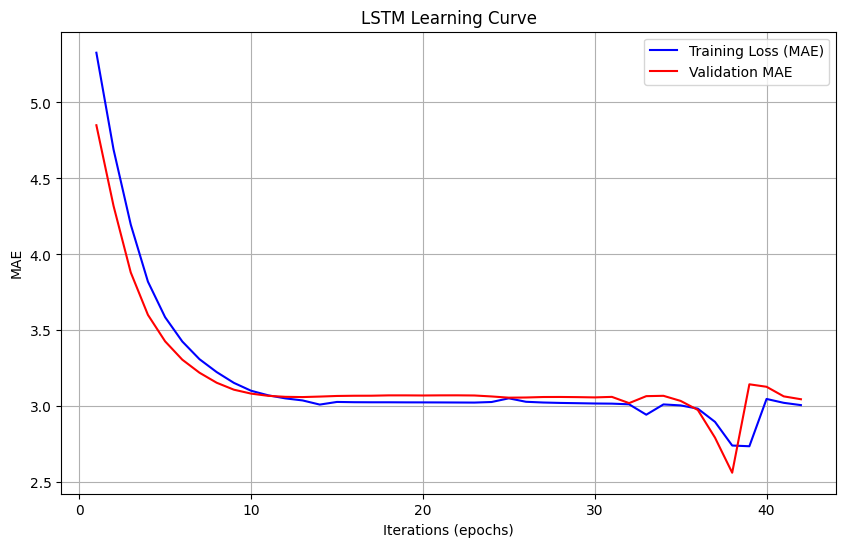

In [20]:
import pandas as pd
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Bidirectional
from keras.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

# 위의 파일을 다 하면 따로 저장한후  불러오기
data = np.load('/kaggle/input/final-data/lstm_dataset_final.npz')
x_data = data['x_data']
y_data = data['y_data']

ratio = 0.75
idx = int(np.ceil(len(x_data) * ratio))

train_data = x_data[:idx]
train_target = y_data[:idx]
val_data = x_data[idx:]
val_target= y_data[idx:]

# 정규화
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data.reshape(-1, train_data.shape[-1])).reshape(train_data.shape)
val_data_scaled = scaler.transform(val_data.reshape(-1, val_data.shape[-1])).reshape(val_data.shape)

# 양방향 모델 구현
x_input = Input(shape=x_data.shape[1:])
bi_lstm_1 = LSTM(32, return_sequences=True)(x_input)
bi_lstm_2 = LSTM(16, return_sequences=True)(bi_lstm_1)
bi_lstm_3 = Bidirectional(LSTM(8))(bi_lstm_2)
output = Dense(1)(bi_lstm_3)

model = Model(x_input, output)
model.compile(loss='mae', optimizer='adam')

# 학습
history = model.fit(train_data_scaled, train_target, batch_size=256, epochs=42, 
                    verbose=0, shuffle=True,
                   validation_data=(val_data_scaled, val_target))

# 학습 기록 가져오기
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'b-', label='Training Loss (MAE)')
plt.plot(epochs, val_loss, 'r-', label='Validation MAE')
plt.legend()
plt.xlabel('Iterations (epochs)')
plt.ylabel('MAE')
plt.title('LSTM Learning Curve')
plt.grid(True)
plt.show()

### --- 최종 : 앙상블 (LightGBM + LSTM) ---

In [29]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from keras.models import Model
from keras.layers import Input, Dense, LSTM
from keras.layers import Bidirectional
from keras.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

# gbm data 불러오기
gbm_data = pd.read_csv('/kaggle/input/final-data/final_feature.csv')
gbm_y_data = pd.read_csv('/kaggle/input/final-data/final_target.csv')
features_select = ['mfcc_5_std', 'iqr', 'mfcc_5_mean', 'mfcc_8_std', 'mfcc_6_std']
gbm_x_data = gbm_data[features_select]

#lstm data 불러오기
lstm_data = np.load('/kaggle/input/final-data/lstm_dataset_final.npz')
lstm_x_data = lstm_data['x_data']
lstm_y_data = lstm_data['y_data']

# K-Fold 초기 설정
k = 5
num_gbm_samples = len(gbm_x_data) // k
num_lstm_samples = len(lstm_x_data) // k

# K-Fold 실행
for i in range(k):
    print(f"--- {i+1} 번째 FOLD 실행 중 ---")
    print("--- LightGBM 실행 중 ---")
    # 검증 데이터와 훈련 데이터 나누기
    gbm_val_data = gbm_x_data.iloc[i*num_gbm_samples : (i+1)*num_gbm_samples] # .iloc 을 사용해야한다는 것을 ai가 고쳐줌
    gbm_val_target = gbm_y_data.iloc[i*num_gbm_samples : (i+1)*num_gbm_samples]
    gbm_train_data = np.concatenate([gbm_x_data.iloc[:i*num_gbm_samples], gbm_x_data.iloc[(i+1)*num_gbm_samples:]], axis=0)
    gbm_train_target = np.concatenate([gbm_y_data.iloc[:i*num_gbm_samples], gbm_y_data.iloc[(i+1)*num_gbm_samples:]], axis=0)
    
    # light gbm 모델 구현
    gbm_model = LGBMRegressor(n_estimators=35, learning_rate=0.04, random_state=42)
    # LSMT 모델 구현
    x_input = Input(shape=lstm_x_data.shape[1:])
    # uni_lstm_1 = LSTM(32, return_sequences=True)(x_input)
    bi_lstm_1 = LSTM(32, return_sequences=True)(x_input)
    bi_lstm_2 = LSTM(16, return_sequences=True)(bi_lstm_1)
    bi_lstm_3 = Bidirectional(LSTM(8))(bi_lstm_2)
    output = Dense(1)(bi_lstm_3)
    
    lstm_model = Model(x_input, output)
    lstm_model.compile(loss='mae', optimizer='adam')
    
    
    # 훈련시작
    gbm_model.fit(gbm_train_data, gbm_train_target)
    # 예측
    gbm_prediction = gbm_model.predict(gbm_val_data)
    # mae
    gbm_mae = mean_absolute_error(gbm_val_target, gbm_prediction)
    print("LightGBM Mean Absolute Error : ", np.mean(gbm_mae))
    
    print("--- LSTM 실행 중 ---")
    # 검증 데이터와 훈련 데이터 나누기
    lstm_val_data = lstm_x_data[i*num_lstm_samples : (i+1)*num_lstm_samples]
    lstm_val_target = lstm_y_data[i*num_lstm_samples : (i+1)*num_lstm_samples]
    lstm_train_data = np.concatenate([lstm_x_data[:i*num_lstm_samples], lstm_x_data[(i+1)*num_lstm_samples:]], axis=0)
    lstm_train_target = np.concatenate([lstm_y_data[:i*num_lstm_samples], lstm_y_data[(i+1)*num_lstm_samples:]], axis=0)

    # 정규화
    scaler = MinMaxScaler()
    lstm_train_scaled = scaler.fit_transform(lstm_train_data.reshape(-1, lstm_train_data.shape[-1])).reshape(lstm_train_data.shape)
    lstm_val_scaled = scaler.transform(lstm_val_data.reshape(-1, lstm_val_data.shape[-1])).reshape(lstm_val_data.shape)
    
    # 훈련 시작
    lstm_model.fit(lstm_train_scaled, lstm_train_target, batch_size=256, epochs=55,
                 verbose=0, shuffle=True)
    # 예측
    lstm_prediction = lstm_model.predict(lstm_val_scaled)
    lstm_prediction_flat = lstm_prediction.flatten()
    # mae
    lstm_mae = mean_absolute_error(lstm_val_target, lstm_prediction_flat)
    print("LSTM Mean Absolute Error : ", np.mean(lstm_mae))
    
    # 기하 평균으로 앙상블
    gbm_pred = np.maximum(gbm_prediction, 0)
    lstm_pred = np.maximum(lstm_prediction_flat, 0)
    
    final_output = np.sqrt(gbm_pred * lstm_pred)
    final_mae = mean_absolute_error(lstm_val_target, final_output)
    print(f"Final Mean Absolute Error : {final_mae:.4f} ")
    
    print(f"--- {i+1}번째 FOLD 실행 종료 ---\n\n")

--- 1 번째 FOLD 실행 중 ---
--- LightGBM 실행 중 ---
LightGBM Mean Absolute Error :  2.25059775849432
--- LSTM 실행 중 ---


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
LSTM Mean Absolute Error :  2.2931545
Final Mean Absolute Error : 2.2186 
--- 1번째 FOLD 실행 종료 ---


--- 2 번째 FOLD 실행 중 ---
--- LightGBM 실행 중 ---
LightGBM Mean Absolute Error :  2.551497729496047
--- LSTM 실행 중 ---


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
LSTM Mean Absolute Error :  3.1034105
Final Mean Absolute Error : 2.6843 
--- 2번째 FOLD 실행 종료 ---


--- 3 번째 FOLD 실행 중 ---
--- LightGBM 실행 중 ---
LightGBM Mean Absolute Error :  2.4457994476992932
--- LSTM 실행 중 ---


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
LSTM Mean Absolute Error :  3.249842
Final Mean Absolute Error : 2.7017 
--- 3번째 FOLD 실행 종료 ---


--- 4 번째 FOLD 실행 중 ---
--- LightGBM 실행 중 ---
LightGBM Mean Absolute Error :  1.5011806243445502
--- LSTM 실행 중 ---


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
LSTM Mean Absolute Error :  1.4717269
Final Mean Absolute Error : 1.4219 
--- 4번째 FOLD 실행 종료 ---


--- 5 번째 FOLD 실행 중 ---
--- LightGBM 실행 중 ---
LightGBM Mean Absolute Error :  2.4555502179071698
--- LSTM 실행 중 ---


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
LSTM Mean Absolute Error :  2.4905763
Final Mean Absolute Error : 2.3811 
--- 5번째 FOLD 실행 종료 ---




## --- Test 파일 대입 ---

In [13]:
import warnings

# "Empty filters"라는 문구가 포함된 경고는 무시하라는 명령입니다.
warnings.filterwarnings("ignore", message="Empty filters detected")

### 1. LightGBM

In [30]:
import pandas as pd
import numpy as np
import librosa
from scipy import fft, signal as sg
from lightgbm import LGBMRegressor
from sklearn.preprocessing import MinMaxScaler
import glob

file_path = '/kaggle/input/test-file/test/*.csv'
files = glob.glob(file_path)
submission = []

# gbm data 불러오기
gbm_data = pd.read_csv('/kaggle/input/final-data/final_feature.csv')
gbm_y_data = pd.read_csv('/kaggle/input/final-data/final_target.csv')
features_select = ['mfcc_5_std', 'iqr', 'mfcc_5_mean', 'mfcc_8_std', 'mfcc_6_std']
gbm_x_data = gbm_data[features_select]

# 데이터 분리
ratio = 0.75
idx = int(np.ceil(len(gbm_x_data) * ratio))

train_data = gbm_x_data.iloc[:idx]
train_target = gbm_y_data.iloc[:idx]
val_data = gbm_x_data.iloc[idx:]
val_target = gbm_y_data.iloc[idx:]

# LightGBM 모델 구현
gbm_model = LGBMRegressor(n_estimators=35, learning_rate=0.04, random_state=42)

# LightGBM 학습
print("LightGBM 모델 학습 중...")
gbm_model.fit(train_data, train_target)
pred = gbm_model.predict(val_data)

val_pred = np.maximum(pred, 0)
val_mae = mean_absolute_error(val_target, val_pred)
print(f"검증 데이터 Mean Absolute Error : {np.mean(val_mae)}")


num = 1
for file in files:
    test_data = pd.read_csv(file)
    segment_id = file.split('/')[-1].split('.')[0]
    gbm_feature = {}

    # lightgbm feature 생성
    data_normalized = test_data['acoustic_data'].astype(np.float32)
    if np.max(np.abs(data_normalized)) > 0:
        data_normalized = data_normalized / np.max(np.abs(data_normalized))
    audio_data = data_normalized.values

    features = []
    gbm_feature['iqr'] = np.percentile(data_normalized, 75) - np.percentile(data_normalized, 25)
    mfccs = librosa.feature.mfcc(y=audio_data, sr=4000000, n_mfcc=13)
    for i in range(13):
        gbm_feature[f'mfcc_{i}_mean'] = np.mean(mfccs[i])
        gbm_feature[f'mfcc_{i}_std'] = np.std(mfccs[i])
    features.append(gbm_feature)
    df_gbm_feature = pd.DataFrame(features)
    gbm_final_feature = df_gbm_feature[features_select]

    # 예측
    gbm_pred = gbm_model.predict(gbm_final_feature, verbose=0)
    
    submission.append({'seg_id':segment_id, 'time_to_failure':gbm_pred[0]})
    
    if(num%500 == 0):
        print("segment_id : ", segment_id)
        print(f"{num}번째 Prediction : {gbm_pred[0]} ")
        print(f"--- {file} 예측 종료 --- \n")
    num += 1

LightGBM 모델 학습 중...
검증 데이터 Mean Absolute Error : 2.293581425117319
segment_id :  seg_ec73d5
500번째 Prediction : 8.784072955926877 
--- /kaggle/input/test-file/test/seg_ec73d5.csv 예측 종료 --- 

segment_id :  seg_16c3a7
1000번째 Prediction : 7.498713620236896 
--- /kaggle/input/test-file/test/seg_16c3a7.csv 예측 종료 --- 

segment_id :  seg_8f25b0
1500번째 Prediction : 8.175148236835764 
--- /kaggle/input/test-file/test/seg_8f25b0.csv 예측 종료 --- 

segment_id :  seg_bb2d77
2000번째 Prediction : 7.404838199904918 
--- /kaggle/input/test-file/test/seg_bb2d77.csv 예측 종료 --- 

segment_id :  seg_0fca83
2500번째 Prediction : 8.784072955926877 
--- /kaggle/input/test-file/test/seg_0fca83.csv 예측 종료 --- 



In [31]:
submission_df = pd.DataFrame(submission)
submission_df

,seg_id,time_to_failure
0,seg_fb8af5,7.498714
1,seg_a35c82,8.784073
2,seg_cec2f2,8.837302
3,seg_176542,8.304702
4,seg_9c3d6a,8.563376
...,...,...
2619,seg_524b39,7.545404
2620,seg_e64dfa,8.330613
2621,seg_046c28,7.498714
2622,seg_1d596d,8.784073


In [32]:
import pandas as pd

sample_df = pd.read_csv('/kaggle/input/submission/sample_submission.csv')
# data_df = pd.read_csv('/kaggle/input/submission/submission.csv')

results = []

for i in range(sample_df.shape[0]):
    standard_seg_id = sample_df['seg_id'].iloc[i]

    for j in range(submission_df.shape[0]):
        current_seg_id = submission_df['seg_id'].iloc[j]
        if standard_seg_id == current_seg_id :
            results.append({'seg_id':current_seg_id, 'time_to_failure':submission_df['time_to_failure'].iloc[j]})
            break
        else:
            continue

results_df = pd.DataFrame(results)
results_df

,seg_id,time_to_failure
0,seg_00030f,8.784073
1,seg_0012b5,7.626757
2,seg_00184e,8.784073
3,seg_003339,8.737288
4,seg_0042cc,8.784073
...,...,...
2619,seg_ff4236,8.784073
2620,seg_ff7478,8.561241
2621,seg_ff79d9,7.498714
2622,seg_ffbd6a,7.498714


In [33]:
results_df.to_csv('lightgbm_only(final_2).csv',index=False)

### 2. LSTM

In [6]:
import pandas as pd
import numpy as np
import librosa
from scipy import fft, signal as sg
from keras.layers import Input, Dense, LSTM, Bidirectional
from keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from keras.metrics import mean_absolute_error
import glob

file_path = '/kaggle/input/test-file/test/*.csv'
files = glob.glob(file_path)
submission = []

#lstm data 불러오기
data = np.load('/kaggle/input/final-data/lstm_dataset_final.npz')
x_data = data['x_data']
y_data = data['y_data']

# 데이터 분할
ratio = 0.75
idx = int(np.ceil(len(x_data) * ratio))

#LSTM
train_data = x_data[:idx]
train_target = y_data[:idx]
val_data = x_data[idx:]
val_target = y_data[idx:]

# 정규화
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data.reshape(-1, train_data.shape[-1])).reshape(train_data.shape)
val_scaled = scaler.transform(val_data.reshape(-1, val_data.shape[-1])).reshape(val_data.shape)

# LSTM 모델 구현
x_input = Input(shape=train_scaled.shape[1:])
bi_lstm_1 = LSTM(32, return_sequences=True)(x_input)
bi_lstm_2 = LSTM(16, return_sequences=True)(bi_lstm_1)
bi_lstm_3 = Bidirectional(LSTM(8))(bi_lstm_2)
output = Dense(1)(bi_lstm_3)

model = Model(x_input, output)
model.compile(loss='mae', optimizer='adam')

# LSTM 학습
print("LSTM 모델 학습 중 ...")
model.fit(train_scaled, train_target, batch_size=256, epochs=55, verbose=0, shuffle=True)
# 검증
pred = model.predict(val_scaled)
pred_flat = pred.flatten()

val_predic = np.maximum(pred_flat, 0)
val_mae = mean_absolute_error(val_target, val_predic)
print(f"검증 데이터 Mean Absolute Error : {val_mae}")

# LSTM feature 생성 함수
def create_lstm_features(segment_signal, time_steps=150):
  step_length = len(segment_signal) // time_steps
  features = []

  for i in range(time_steps):
    start = i * step_length
    end = start + step_length
    sub_signal = segment_signal[start:end]

    #Spectral centroid
    data_normalized = sub_signal.astype(np.float32)
    if np.max(np.abs(data_normalized)) > 0:
      data_normalized = data_normalized / np.max(np.abs(data_normalized))

    spectral_cent = librosa.feature.spectral_centroid(y=data_normalized.values, sr=4000000, n_fft=256)[0]
    spectral_roll = librosa.feature.spectral_rolloff(y=data_normalized.values, sr=4000000, n_fft=256)[0]
    # FFT
    fft_values = np.abs(fft.fft(sub_signal))
    fft_values = fft_values[:len(fft_values) // 2]

    #Signal
    zero_crossings = np.where(np.diff(np.sign(sub_signal)))[0]
    peaks, properties = sg.find_peaks(sub_signal, height=0)
    neg_peaks, neg_properties = sg.find_peaks(-sub_signal, height=0)

    step_features = [
        np.mean(sub_signal),
        np.std(sub_signal),
        np.min(sub_signal),
        np.max(sub_signal),
        np.median(sub_signal),
        np.mean(spectral_cent),
        np.std(spectral_cent),
        np.min(spectral_cent),
        np.max(spectral_cent),
        np.median(spectral_cent),
        np.mean(spectral_roll),
        np.std(spectral_roll),
        np.min(spectral_roll),
        np.max(spectral_roll),
        np.median(spectral_roll),
        np.mean(fft_values),
        np.std(fft_values),
        np.min(fft_values),
        np.max(fft_values),
        np.median(fft_values),
        len(zero_crossings)/len(sub_signal),
        len(peaks),
        np.mean(properties['peak_heights']) if len(peaks) > 0 else 0,
        np.max(properties['peak_heights']) if len(peaks) > 0 else 0,
        np.std(properties['peak_heights']) if len(peaks) > 0 else 0,
        len(neg_peaks),
        np.mean(neg_properties['peak_heights']) if len(neg_peaks) > 0 else 0,
        np.max(neg_properties['peak_heights']) if len(neg_peaks) > 0 else 0
    ]
    features.append(step_features)

  return np.array(features)

num = 1
for file in files:
    test_data = pd.read_csv(file)
    segment_id = file.split('/')[-1].split('.')[0]
    feature_li = []
    
    # lstm feature 생성
    noise = np.random.normal(0, 0.01, len(test_data))
    signal = test_data['acoustic_data'].astype(float)
    signal -= np.median(signal)
    signal += noise

    sequence_features = create_lstm_features(signal)
    
    feature_li.append(sequence_features)

    test_data = np.array(feature_li)

    # 정규화
    test_scaled = scaler.transform(test_data.reshape(-1, test_data.shape[-1])).reshape(test_data.shape)

    # 예측
    test_pred = model.predict(test_scaled, verbose=0)
    test_pred_flat = test_pred.flatten()

    submission.append({'seg_id':segment_id, 'time_to_failure': test_pred_flat[0]})
    
    if(num%500 == 0):
        print("segment_id : ", segment_id)
        print(f"{num}번째 Prediction : {test_pred_flat[0]} ")
        print(f"--- {file} 예측 종료 --- \n")
    num += 1

LSTM 모델 학습 중 ...
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
검증 데이터 Mean Absolute Error : 2.9283854961395264
segment_id :  seg_ec73d5
500번째 Prediction : 4.335300922393799 
--- /kaggle/input/test-file/test/seg_ec73d5.csv 예측 종료 --- 

segment_id :  seg_16c3a7
1000번째 Prediction : 4.54485559463501 
--- /kaggle/input/test-file/test/seg_16c3a7.csv 예측 종료 --- 

segment_id :  seg_8f25b0
1500번째 Prediction : 4.932185649871826 
--- /kaggle/input/test-file/test/seg_8f25b0.csv 예측 종료 --- 

segment_id :  seg_bb2d77
2000번째 Prediction : 4.662539482116699 
--- /kaggle/input/test-file/test/seg_bb2d77.csv 예측 종료 --- 

segment_id :  seg_0fca83
2500번째 Prediction : 4.20772647857666 
--- /kaggle/input/test-file/test/seg_0fca83.csv 예측 종료 --- 



In [7]:
submission_df = pd.DataFrame(submission)
submission_df

,seg_id,time_to_failure
0,seg_fb8af5,4.069261
1,seg_a35c82,4.847497
2,seg_cec2f2,4.744505
3,seg_176542,4.812795
4,seg_9c3d6a,4.850650
...,...,...
2619,seg_524b39,4.630791
2620,seg_e64dfa,4.738471
2621,seg_046c28,4.534875
2622,seg_1d596d,4.012613


In [8]:
import pandas as pd

sample_df = pd.read_csv('/kaggle/input/submission/sample_submission.csv')
# data_df = pd.read_csv('/kaggle/input/submission/submission.csv')

results = []

for i in range(sample_df.shape[0]):
    standard_seg_id = sample_df['seg_id'].iloc[i]

    for j in range(submission_df.shape[0]):
        current_seg_id = submission_df['seg_id'].iloc[j]
        if standard_seg_id == current_seg_id :
            results.append({'seg_id':current_seg_id, 'time_to_failure':submission_df['time_to_failure'].iloc[j]})
            break
        else:
            continue

results_df = pd.DataFrame(results)
results_df

,seg_id,time_to_failure
0,seg_00030f,4.500402
1,seg_0012b5,4.737736
2,seg_00184e,4.822128
3,seg_003339,4.825032
4,seg_0042cc,4.799580
...,...,...
2619,seg_ff4236,4.196393
2620,seg_ff7478,4.855478
2621,seg_ff79d9,4.430770
2622,seg_ffbd6a,3.367513


In [9]:
results_df.to_csv('lstm_only(final).csv',index=False)

### 3. 앙상블

In [35]:
import pandas as pd
import numpy as np
import librosa
from scipy import fft, signal as sg
from lightgbm import LGBMRegressor
from keras.layers import Input, Dense, LSTM, Bidirectional
from keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from keras.metrics import mean_absolute_error
import glob

file_path = '/kaggle/input/test-file/test/*.csv'
files = glob.glob(file_path)
submission = []

# gbm data 불러오기
gbm_data = pd.read_csv('/kaggle/input/final-data/final_feature.csv')
gbm_y_data = pd.read_csv('/kaggle/input/final-data/final_target.csv')
features_select = ['mfcc_5_std', 'iqr', 'mfcc_5_mean', 'mfcc_8_std', 'mfcc_6_std']
gbm_x_data = gbm_data[features_select]

#lstm data 불러오기
lstm_data = np.load('/kaggle/input/final-data/lstm_dataset_final.npz')
lstm_x_data = lstm_data['x_data']
lstm_y_data = lstm_data['y_data']

# 데이터 분할
ratio = 0.75
gbm_idx= int(np.ceil(len(gbm_x_data) * ratio))
lstm_idx = int(np.ceil(len(lstm_x_data) * ratio))
# LightGBM
gbm_train_data = gbm_x_data.iloc[:gbm_idx]
gbm_train_target = gbm_y_data.iloc[:gbm_idx]
gbm_val_data = gbm_x_data.iloc[gbm_idx:]
gbm_val_target = gbm_y_data.iloc[gbm_idx:]
#LSTM
lstm_train_data = lstm_x_data[:lstm_idx]
lstm_train_target = lstm_y_data[:lstm_idx]
lstm_val_data = lstm_x_data[lstm_idx:]
lstm_val_target = lstm_y_data[lstm_idx:]

# 정규화
scaler = MinMaxScaler()
lstm_train_scaled = scaler.fit_transform(lstm_train_data.reshape(-1, lstm_train_data.shape[-1])).reshape(lstm_train_data.shape)
lstm_val_scaled = scaler.transform(lstm_val_data.reshape(-1, lstm_val_data.shape[-1])).reshape(lstm_val_data.shape)

# LightGBM 모델 구현
gbm_model = LGBMRegressor(n_estimators=35, learning_rate=0.04, random_state=42)

# LSTM 모델 구현
x_input = Input(shape=lstm_train_scaled.shape[1:])
bi_lstm_1 = LSTM(32, return_sequences=True)(x_input)
bi_lstm_2 = LSTM(16, return_sequences=True)(bi_lstm_1)
bi_lstm_3 = Bidirectional(LSTM(8))(bi_lstm_2)
output = Dense(1)(bi_lstm_3)

lstm_model = Model(x_input, output)
lstm_model.compile(loss='mae', optimizer='adam')

# LightGBM 학습
print("LightGBM 모델 학습 중...")
gbm_model.fit(gbm_train_data, gbm_train_target)

# LSTM 학습
print("LSTM 모델 학습 중 ...")
lstm_model.fit(lstm_train_scaled, lstm_train_target, batch_size=256, epochs=55, verbose=0, shuffle=True)

# 검증 데이터
gbm_val_predic = gbm_model.predict(gbm_val_data)
lstm_val_predic = lstm_model.predict(lstm_val_scaled)
lstm_val_predic_flat = lstm_val_predic.flatten()

gbm_val_predic = np.maximum(gbm_val_predic, 0)
lstm_val_predic = np.maximum(lstm_val_predic_flat, 0)
final_val_predic = np.sqrt(gbm_val_predic * lstm_val_predic)

gbm_val_mae = mean_absolute_error(gbm_val_target, gbm_val_predic)
lstm_val_mae = mean_absolute_error(lstm_val_target, lstm_val_predic)
ensem_val_mae = mean_absolute_error(lstm_val_target, final_val_predic)
print(f"LightGBM Mean Absolute Error : {np.mean(gbm_val_mae)}")
print(f"LSTM Mean Absolute Error : {lstm_val_mae}")
print(f"Ensemble Mean Absolute Error : {ensem_val_mae} ")

# LSTM feature 생성 함수
def create_lstm_features(segment_signal, time_steps=150):
  step_length = len(segment_signal) // time_steps
  lstm_features = []

  for i in range(time_steps):
    start = i * step_length
    end = start + step_length
    sub_signal = segment_signal[start:end]

    #Spectral centroid
    data_normalized = sub_signal.astype(np.float32)
    if np.max(np.abs(data_normalized)) > 0:
      data_normalized = data_normalized / np.max(np.abs(data_normalized))

    spectral_cent = librosa.feature.spectral_centroid(y=data_normalized.values, sr=4000000, n_fft=256)[0]
    spectral_roll = librosa.feature.spectral_rolloff(y=data_normalized.values, sr=4000000, n_fft=256)[0]
    # FFT
    fft_values = np.abs(fft.fft(sub_signal))
    fft_values = fft_values[:len(fft_values) // 2]

    #Signal
    zero_crossings = np.where(np.diff(np.sign(sub_signal)))[0]
    peaks, properties = sg.find_peaks(sub_signal, height=0)
    neg_peaks, neg_properties = sg.find_peaks(-sub_signal, height=0)

    step_features = [
        np.mean(sub_signal),
        np.std(sub_signal),
        np.min(sub_signal),
        np.max(sub_signal),
        np.median(sub_signal),
        np.mean(spectral_cent),
        np.std(spectral_cent),
        np.min(spectral_cent),
        np.max(spectral_cent),
        np.median(spectral_cent),
        np.mean(spectral_roll),
        np.std(spectral_roll),
        np.min(spectral_roll),
        np.max(spectral_roll),
        np.median(spectral_roll),
        np.mean(fft_values),
        np.std(fft_values),
        np.min(fft_values),
        np.max(fft_values),
        np.median(fft_values),
        len(zero_crossings)/len(sub_signal),
        len(peaks),
        np.mean(properties['peak_heights']) if len(peaks) > 0 else 0,
        np.max(properties['peak_heights']) if len(peaks) > 0 else 0,
        np.std(properties['peak_heights']) if len(peaks) > 0 else 0,
        len(neg_peaks),
        np.mean(neg_properties['peak_heights']) if len(neg_peaks) > 0 else 0,
        np.max(neg_properties['peak_heights']) if len(neg_peaks) > 0 else 0
    ]
    lstm_features.append(step_features)

  return np.array(lstm_features)

num = 1
for file in files:
    test_data = pd.read_csv(file)
    segment_id = file.split('/')[-1].split('.')[0]
    gbm_feature = {}
    lstm_feature_li = []

    # lightgbm feature 생성
    data_normalized = test_data['acoustic_data'].astype(np.float32)
    if np.max(np.abs(data_normalized)) > 0:
        data_normalized = data_normalized / np.max(np.abs(data_normalized))
    audio_data = data_normalized.values

    features = []
    gbm_feature['iqr'] = np.percentile(data_normalized, 75) - np.percentile(data_normalized, 25)
    mfccs = librosa.feature.mfcc(y=audio_data, sr=4000000, n_mfcc=13)
    for i in range(13):
        gbm_feature[f'mfcc_{i}_mean'] = np.mean(mfccs[i])
        gbm_feature[f'mfcc_{i}_std'] = np.std(mfccs[i])
    features.append(gbm_feature)
    df_gbm_feature = pd.DataFrame(features)
    gbm_final_feature = df_gbm_feature[features_select]
    
    # lstm feature 생성
    noise = np.random.normal(0, 0.01, len(test_data))
    signal = test_data['acoustic_data'].astype(float)
    signal -= np.median(signal)
    signal += noise

    sequence_features = create_lstm_features(signal)
    
    lstm_feature_li.append(sequence_features)

    lstm_test_data = np.array(lstm_feature_li)

    # 정규화
    lstm_test_scaled = scaler.transform(lstm_test_data.reshape(-1, lstm_test_data.shape[-1])).reshape(lstm_test_data.shape)
    
    # 예측
    gbm_pred = gbm_model.predict(gbm_final_feature, verbose=0)
    lstm_pred = lstm_model.predict(lstm_test_scaled, verbose=0)
    lstm_pred_flat = lstm_pred.flatten()

    # 기하 평균
    gbm_pred = np.maximum(gbm_pred, 0)
    lstm_pred = np.maximum(lstm_pred_flat, 0)
    
    final_output = np.sqrt(gbm_pred * lstm_pred)
    submission.append({'seg_id':segment_id, 'time_to_failure':final_output[0]})
    
    if(num%500 == 0):
        print("segment_id : ", segment_id)
        print(f"{num}번째 Prediction : {final_output[0]} ")
        print(f"--- {file} 예측 종료 --- \n")
    num += 1

LightGBM 모델 학습 중...
LSTM 모델 학습 중 ...
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
LightGBM Mean Absolute Error : 2.293581425117319
LSTM Mean Absolute Error : 2.308887004852295
Ensemble Mean Absolute Error : 2.243987108760354 
segment_id :  seg_ec73d5
500번째 Prediction : 5.241408845588788 
--- /kaggle/input/test-file/test/seg_ec73d5.csv 예측 종료 --- 

segment_id :  seg_16c3a7
1000번째 Prediction : 4.694738239090754 
--- /kaggle/input/test-file/test/seg_16c3a7.csv 예측 종료 --- 

segment_id :  seg_8f25b0
1500번째 Prediction : 7.642118105052468 
--- /kaggle/input/test-file/test/seg_8f25b0.csv 예측 종료 --- 

segment_id :  seg_bb2d77
2000번째 Prediction : 4.988704679308979 
--- /kaggle/input/test-file/test/seg_bb2d77.csv 예측 종료 --- 

segment_id :  seg_0fca83
2500번째 Prediction : 4.865709232579113 
--- /kaggle/input/test-file/test/seg_0fca83.csv 예측 종료 --- 



### dataframe 으로 변환

In [36]:
submission_df = pd.DataFrame(submission)
submission_df

,seg_id,time_to_failure
0,seg_fb8af5,4.367627
1,seg_a35c82,7.922527
2,seg_cec2f2,7.899223
3,seg_176542,7.702639
4,seg_9c3d6a,7.805023
...,...,...
2619,seg_524b39,6.882604
2620,seg_e64dfa,7.684236
2621,seg_046c28,4.718652
2622,seg_1d596d,5.734047


submission_sample 에 맞춰서 넣기

In [37]:
import pandas as pd

sample_df = pd.read_csv('/kaggle/input/submission/sample_submission.csv')

results = []

for i in range(sample_df.shape[0]):
    standard_seg_id = sample_df['seg_id'].iloc[i]

    for j in range(submission_df.shape[0]):
        current_seg_id = submission_df['seg_id'].iloc[j]
        if standard_seg_id == current_seg_id :
            results.append({'seg_id':current_seg_id, 'time_to_failure':submission_df['time_to_failure'].iloc[j]})
            break
        else:
            continue

results_df = pd.DataFrame(results)
results_df

,seg_id,time_to_failure
0,seg_00030f,5.952279
1,seg_0012b5,5.733587
2,seg_00184e,6.186852
3,seg_003339,7.904664
4,seg_0042cc,7.915876
...,...,...
2619,seg_ff4236,5.894514
2620,seg_ff7478,7.070888
2621,seg_ff79d9,3.839090
2622,seg_ffbd6a,4.638279


In [38]:
results_df.to_csv('result_5.csv', index=False)